# AEDC

Main research question:

    Can we infer the source of a sound recording from the tract and E (dB) data?

Subquestions:

    How can we, based on the tract and E data, define a suitable set of features?
    Which algorithms can be used to solve this task?
    How does performance of the classifiers built depend on the machine learning algorithm and their parameters?
    How does performance of the classifiers built depend on feature extraction parameters?

In [53]:
#imports 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from tables import *
import h5py
import os
import pandas as pd
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import statistics
from fast_histogram import histogram1d, histogram2d
from scipy import stats
import math
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

**Two visualizations of the raw data**

*Plots of Energy, s_tract and f_tract features of two files, frecuency vs time*

This is to have a better idea about the data used, for later work with it


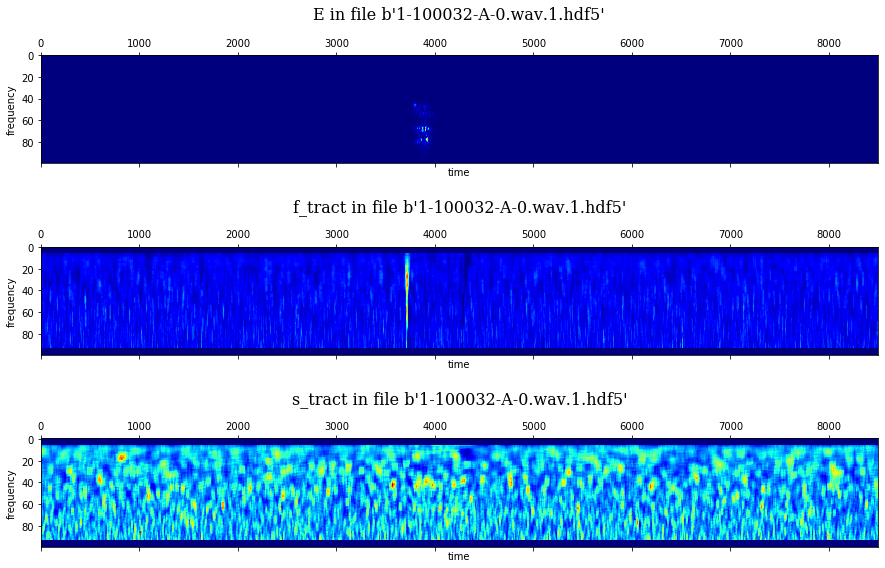

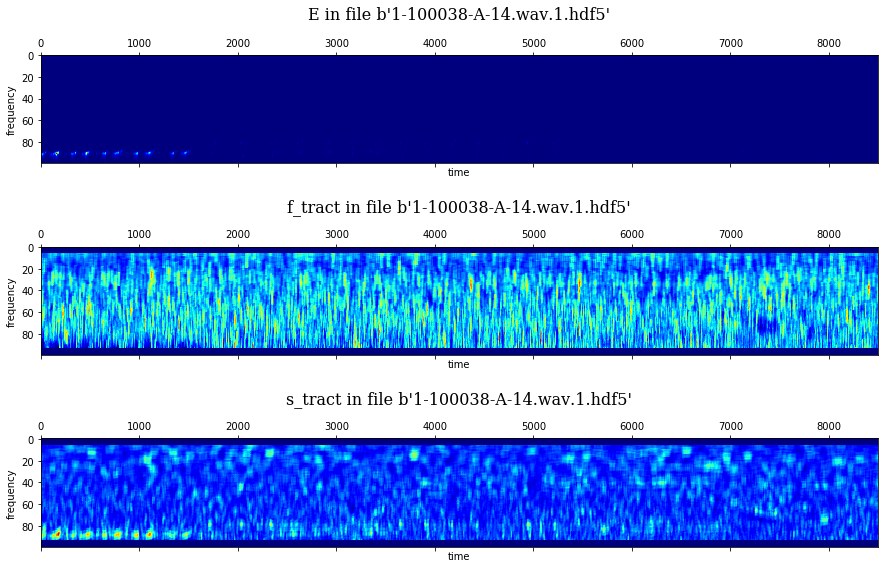

In [38]:
directory2 = os.fsencode("/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/")
aspec = 11.00
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
pad=30
cnt2 = 0
for file in os.listdir(directory2):
    path3 = os.path.join(directory2, file)
    f3 = h5py.File(path3,"r")
    aT=f3["E"]
    bT=f3["f_tract"]
    cT=f3["s_tract"]
    fig, ax = plt.subplots(3, 1, figsize=(15,10))
    ax[0].set_title('E in file '+format(file), fontdict=font,pad=pad)
    ax[0].matshow(aT, interpolation='nearest', cmap=cm.jet), ax[0].set_xlabel('time'),ax[0].set_ylabel('frequency')
    ax[0].set_aspect(aspec)
    ax[1].set_title('f_tract in file '+format(file), fontdict=font,pad=pad)
    ax[1].matshow(bT, interpolation='nearest', cmap=cm.jet), ax[1].set_xlabel('time'),ax[1].set_ylabel('frequency')
    ax[1].set_aspect(aspec)
    ax[2].set_title('s_tract in file '+format(file), fontdict=font,pad=pad)
    ax[2].matshow(cT, interpolation='nearest', cmap=cm.jet), ax[2].set_xlabel('time'),ax[2].set_ylabel('frequency')
    ax[2].set_aspect(aspec)

    cnt2 += 1
    plt.show()
    if (cnt2 >= 2):
        break

# Feature sets construction

From this point I will perform the feature construction, buiding multiple feature sets that I will save in h5py files and open for their use in the SVM, K-Means and HAC algorithms

I need to feed my algorithms with features that define as precise as possible the characteristic frecuencies of the classes. I will take each file, slice the f_tract, s_tract and E features into three arrays each, leaving out the rows of zeros of s_tract, f_tract and E. Then I will create histograms with appropiate frecuency limits. To know those limits I took one of the clases (dog) and I analysed the average maximum and minimum frecuecies, and plotted 5 histograms to make the decision of the range of the histograms used for the feature sets. 

The labeled datasets were con-sequently arranged into 5 uniformly sized cross-validation folds, ensuring that clips originating from the same initial source file are always contained in a single fold, therefore, choosing the ammount of data that I take for training and for testing (I will need this later for the SVM algorithm) should not separate files from the same fold. The more folds I choose for training the more accurate my SVM algorithm is going to make predictions, and the more folds I use for testing the more accurate are going to be the restults of my testing, and consecuently, I neeed to find a balance. For this assignment I choose 3 folds for training and 2 folds for testing. In the K-means based on mayority vote, and HAC algorithms I merged the training and testing data.



In [14]:
'''
Find out average maximum and minumum frecuency values of 'dog' class, for s_tract, f_tract and E

'''
csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
fold_cat = pd.DataFrame(csv, columns= ['fold','category'])
FT_max=0
ST_max=0
ET_max=0
FT_min=0
ST_min=0
ET_min=0
cnt=0
for i in animals:
    for index, row in fold_cat.iterrows():
        categories = row['category']
        if(categories=='dog'): 
                filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
                ff = h5py.File(filenamej,"r")
                fT=ff["f_tract"][6:94,:].flatten()#cut rows of zeros and flatten
                sT=ff["s_tract"][6:94,:].flatten()
                eT=ff["E"][::].flatten()
                FT_max=FT_max+max(fT)
                ST_max=ST_max+max(sT)
                ET_max=ET_max+max(eT)
                FT_min=FT_min+min(fT)
                ST_min=ST_min+min(sT)
                ET_min=ET_min+min(eT)
                cnt+= 1
print('average maximum f_tract frecuency for dog class = ', (FT_max/cnt))
print('average maximum s_tract frecuency for dog class = ', (ST_max/cnt))
print('average maximum E frecuency for dog class = ', (ET_max/cnt))

print('average minimum f_tract frecuency for dog class = ', (FT_min/cnt))
print('average minimum s_tract frecuency for dog class = ', (ST_min/cnt))
print('average minimum E frecuency for dog class = ', (ET_min/cnt))

average maximum f_tract frecuency for dog class =  178.45217094421386
average maximum s_tract frecuency for dog class =  194.62383995056152
average maximum E frecuency for dog class =  1281897888153.6
average minimum f_tract frecuency for dog class =  1.9115785785019397
average minimum s_tract frecuency for dog class =  3.201903671398759
average minimum E frecuency for dog class =  0.10942082171938665


With the values obtained I stablished the limits of the histograms. I'm plotting the histograms of a 'dog' file, one for each feature (f_tract, s_tract and E). By observing them I'll determine the limits of the bins I'll use for building my features, that'll I'll use for different algorithms.

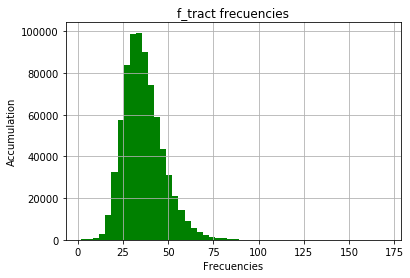

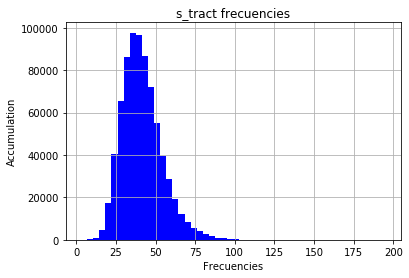

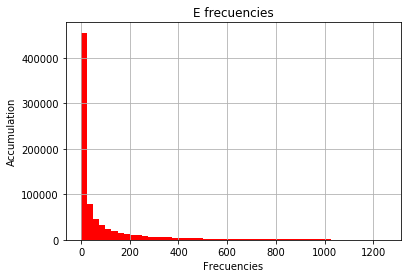

In [45]:
'''
Plot histograms of a 'dog' file to determine the frecuency limits appropiate for my feature sets construction
'''
import matplotlib.pyplot as plt
cnt=0
for index, row in fold_cat.iterrows():
    categories = row['category']
    if(categories=='dog'): 
            filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
            ff = h5py.File(filenamej,"r")
            cnt+=1
            fT=ff["f_tract"][6:94,:].flatten()
            sT=ff["s_tract"][6:94,:].flatten()
            eT=ff["E"][:,:].flatten()
            
            #f_tract histogram of file i
            n, bins, patches = plt.hist(fT, bins=50, range=[1.88,170.15], facecolor='g') #plt.hist makes bins of the same range. If bins=3, then, in this case, each bin has a range of 56 ((170.15-1.88)/3)
            plt.xlabel('Frecuencies')
            plt.ylabel('Accumulation')
            plt.title('f_tract frecuencies')
            plt.grid(True)
            plt.show()
            
            #s_tract histogram of file i
            n, bins, patches = plt.hist(sT, bins=50, range=[3,195], facecolor='b')
            plt.xlabel('Frecuencies')
            plt.ylabel('Accumulation')
            plt.title('s_tract frecuencies')
            plt.grid(True)
            plt.show()
            
            #E histogram of file i
            n, bins, patches = plt.hist(eT, bins=50, range=[0,1250], facecolor='r')#although the previously obtained average maximum is 1281897888153.6, most of the fecuencies are allocated below 1250. If I plot the histogram with a rage [0,1281897888153.6], I can only see a vertical line of frecuecies around 0
            plt.xlabel('Frecuencies')
            plt.ylabel('Accumulation')
            plt.title('E frecuencies')
            plt.grid(True)
            plt.show()
            if(cnt==1):
                break

Range for histograms for building my features:
 
f_tract:[20,40]

s_tract:[25-55]

E:[0,50]

Note: histogram1d divides these ranges into bins of same width.
Example: if the range is [0,10] and I have 5 bins, the upper limits of the bins will be [2,4,6,8,10]

Now I start my feature sets construction. Each set is built in the same way, but variating the number of bins used for the histograms, therefore the resulting feature matrices will be wider the more bins are used. For instance, for 2 bins:

3 features: f_tract, s_tract, E

3 slices per feature: 3x3

2 frecuency bins by slice: 3x3x2=18

1200 files from folds 1, 2 and 3 (training data): 1200x18 matrix of frecuencies for training data

800 files from folds 4 and 5 (testing data): 800x18 matrix of frecuencies for testing data

Put together training and testing data (k-means and HAC): 2000x18 matrix

The more bins, the more information the algorithms receive, and the better prediction accuracies I am expecting to obtain.

Note: I used tqdm in the for loop that goes through the files, and the information about each file being processed occupied too many pages, therefore I converted those cells to markdowns and then back to code, but din't run it again because I already had the feature sets saved.



In [ ]:
'''
Construction of the first feature set, with 2 bins
'''
csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
fold_cat = pd.DataFrame(csv, columns= ['fold','category'])
bins=2
cnt=0
cnt2=0
X_train=np.zeros([1200,(bins*9)])#1200 files from folds 1, 2 and 3 (training data)
X_test=np.zeros([800,(bins*9)])#800 files from folds 4 and 5 (testing data)
Y_train=np.zeros([1200,1])#this will save indexes that will be consulted later for obtaining the labels (class) of each file. If I try directly to save the labels I can't save the information in and h5py file
Y_test=np.zeros([800,1])
for index, row in tqdm(fold_cat.iterrows()):
    categories = row['category']
    folds=row['fold']
    if(folds==1 or folds==2 or folds==3): #training data: folds 1,2 and 3
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        #cut rows of zeros, divide the feature in three parts and flatten
        fT=ff["f_tract"][6:35,:].flatten()
        fT1=ff["f_tract"][35:64,:].flatten()
        fT2=ff["f_tract"][64:94,:].flatten()
        sT=ff["s_tract"][6:35,:].flatten()
        sT1=ff["s_tract"][35:64,:].flatten()
        sT2=ff["s_tract"][64:94,:].flatten()
        ET=ff["E"][0:30,:].flatten()
        ET1=ff["E"][30:60,:].flatten()
        ET2=ff["E"][60:100,:].flatten()
        #calculate histograms
        frequency_f = histogram1d(fT,range=[20,40], bins=bins)#histograms of a certain number of bins, with the range stablished in the previous step. 
        frequency_f1 = histogram1d(fT1,range=[20,40], bins=bins)#the range is devided equaly in the number of bins. If I have to bins and the range is [20,40] each bin has a size of 20
        frequency_f2 = histogram1d(fT2,range=[20,40], bins=bins)
        frequency_s = histogram1d(sT,range=[25,55], bins=bins)
        frequency_s1 = histogram1d(sT1,range=[25,55], bins=bins)
        frequency_s2 = histogram1d(sT2,range=[25,55], bins=bins)
        frequency_E = histogram1d(ET,range=[0,50], bins=bins)
        frequency_E1 = histogram1d(ET1,range=[0,50], bins=bins)
        frequency_E2 = histogram1d(ET2,range=[0,50], bins=bins)            
        frequencies_f=np.append(np.append(frequency_f,frequency_f1),frequency_f2)
        frequencies_s=np.append(np.append(frequency_s,frequency_s1),frequency_s2)
        frequencies_E=np.append(np.append(frequency_E,frequency_E1),frequency_E2)
        X_train[cnt]=np.append(np.append(frequencies_f,frequencies_s),frequencies_E,axis=0)#frecuencies from the bins (f_tract, s_tract and E) for the files from folds 1,2 and 3
        Y_train[cnt]=index
        cnt+=1
    elif(folds==4 or folds==5): #testing data: folds 4 and 5 
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        #cut rows of zeros, divide the feature in three parts and flatten
        fT=ff["f_tract"][6:35,:].flatten()
        fT1=ff["f_tract"][35:64,:].flatten()
        fT2=ff["f_tract"][64:94,:].flatten()
        sT=ff["s_tract"][6:35,:].flatten()
        sT1=ff["s_tract"][35:64,:].flatten()
        sT2=ff["s_tract"][64:94,:].flatten()
        ET=ff["E"][0:30,:].flatten()
        ET1=ff["E"][30:60,:].flatten()
        ET2=ff["E"][60:100,:].flatten()
        #calculate histograms
        frequency_f = histogram1d(fT,range=[20,40], bins=bins)
        frequency_f1 = histogram1d(fT1,range=[20,40], bins=bins)
        frequency_f2 = histogram1d(fT2,range=[20,40], bins=bins)
        frequency_s = histogram1d(sT,range=[25,55], bins=bins)
        frequency_s1 = histogram1d(sT1,range=[25,55], bins=bins)
        frequency_s2 = histogram1d(sT2,range=[25,55], bins=bins)
        frequency_E = histogram1d(ET,range=[0,50], bins=bins)
        frequency_E1 = histogram1d(ET1,range=[0,50], bins=bins)
        frequency_E2 = histogram1d(ET2,range=[0,50], bins=bins)
        frequencies_f=np.append(np.append(frequency_f,frequency_f1),frequency_f2)
        frequencies_s=np.append(np.append(frequency_s,frequency_s1),frequency_s2)
        frequencies_E=np.append(np.append(frequency_E,frequency_E1),frequency_E2)
        X_test[cnt2]=np.append(np.append(frequencies_f,frequencies_s),frequencies_E,axis=0)
        Y_test[cnt2]=index
        cnt2+=1

In [193]:
#save the train and test data in h5py files
X_train_2bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_train_2bins.hdf5', mode = 'w')
X_train_2bins.create_dataset('X_train_2bins', data=X_train)
X_train_2bins.close()

Y_train_2bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_train_2bins.hdf5', mode = 'w')
Y_train_2bins.create_dataset('Y_train_2bins', data=Y_train)
Y_train_2bins.close()

X_test_2bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_test_2bins.hdf5', mode = 'w')
X_test_2bins.create_dataset('X_test_2bins', data=X_test)
X_test_2bins.close()

Y_test_2bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_test_2bins.hdf5', mode = 'w')
Y_test_2bins.create_dataset('Y_test_2bins', data=Y_test)
Y_test_2bins.close()

In [70]:
#opens the Y_train_2bins file and converts the array of indexes into an array with labels
Y_train_2bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_train_2bins.hdf5', mode = 'r+')
Y_train_2bins = Y_train_2bins['Y_train_2bins']
Y_train_2bins_np = Y_train_2bins
Y_train_2bins_list=list()

csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
classes = pd.DataFrame(csv, columns= ['category'])

for index, row in classes.iterrows():
    categories = row['category']
    for i in Y_train_2bins_np:
        if(index==i):
            Y_train_2bins_list.append(categories)
            
Y_train_2bins_labels=np.array(Y_train_2bins_list)

In [71]:
#opens the Y_test_2bins file and converts the array of indexes into an array with labels
Y_test_2bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_test_2bins.hdf5', mode = 'r+')
Y_test_2bins = Y_test_2bins['Y_test_2bins']
Y_test_2bins_np = Y_test_2bins
Y_test_2bins_list=list()

csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
classes = pd.DataFrame(csv, columns= ['category'])

for index, row in classes.iterrows():
    categories = row['category']
    for i in Y_test_2bins_np:
        if(index==i):
            Y_test_2bins_list.append(categories)
    
Y_test_2bins_labels=np.array(Y_test_2bins_list)

In [72]:
#converst the 'X_train_2bins' and 'X_test_2bins' h5py files and converts obtains np arrays
X_train_2bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_train_2bins.hdf5', mode = 'r+')
X_train_2bins=X_train_2bins['X_train_2bins']
X_train_2bins=np.array(X_train_2bins)

X_test_2bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_test_2bins.hdf5', mode = 'r+')
X_test_2bins=X_test_2bins['X_test_2bins']
X_test_2bins=np.array(X_test_2bins)


In [ ]:
#Here I calculate new features changing the number of bins to 3
csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
fold_cat = pd.DataFrame(csv, columns= ['fold','category'])
bins=3
cnt=0
cnt2=0
X_train=np.zeros([1200,(bins*9)])#1200 files from folds 1, 2 and 3 (training data)
X_test=np.zeros([800,(bins*9)])#800 files from folds 4 and 5 (testing data)
Y_train=np.zeros([1200,1])#this will save indexes that will be consulted later for obtaining the labels (class) of each file. If I try directly to save the labels I can't save the information in and h5py file
Y_test=np.zeros([800,1])
for index, row in tqdm(fold_cat.iterrows()):
    categories = row['category']
    folds=row['fold']
    if(folds==1 or folds==2 or folds==3): #training data: folds 1,2 and 3
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        #cut rows of zeros, divide the feature in three parts and flatten
        fT=ff["f_tract"][6:35,:].flatten()
        fT1=ff["f_tract"][35:64,:].flatten()
        fT2=ff["f_tract"][64:94,:].flatten()
        sT=ff["s_tract"][6:35,:].flatten()
        sT1=ff["s_tract"][35:64,:].flatten()
        sT2=ff["s_tract"][64:94,:].flatten()
        ET=ff["E"][0:30,:].flatten()
        ET1=ff["E"][30:60,:].flatten()
        ET2=ff["E"][60:100,:].flatten()
        #calculate histograms
        frequency_f = histogram1d(fT,range=[20,40], bins=bins)#histograms of a certain number of bins, with the range stablished in the previous step. 
        frequency_f1 = histogram1d(fT1,range=[20,40], bins=bins)#the range is devided equaly in the number of bins. If I have to bins and the range is [20,40] each bin has a size of 20
        frequency_f2 = histogram1d(fT2,range=[20,40], bins=bins)
        frequency_s = histogram1d(sT,range=[25,55], bins=bins)
        frequency_s1 = histogram1d(sT1,range=[25,55], bins=bins)
        frequency_s2 = histogram1d(sT2,range=[25,55], bins=bins)
        frequency_E = histogram1d(ET,range=[0,50], bins=bins)
        frequency_E1 = histogram1d(ET1,range=[0,50], bins=bins)
        frequency_E2 = histogram1d(ET2,range=[0,50], bins=bins)            
        frequencies_f=np.append(np.append(frequency_f,frequency_f1),frequency_f2)
        frequencies_s=np.append(np.append(frequency_s,frequency_s1),frequency_s2)
        frequencies_E=np.append(np.append(frequency_E,frequency_E1),frequency_E2)
        X_train[cnt]=np.append(np.append(frequencies_f,frequencies_s),frequencies_E,axis=0)#frecuencies from the bins (f_tract, s_tract and E) for the files from folds 1,2 and 3
        Y_train[cnt]=index
        cnt+=1
    elif(folds==4 or folds==5): #testing data: folds 4 and 5 
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        #cut rows of zeros, divide the feature in three parts and flatten
        fT=ff["f_tract"][6:35,:].flatten()
        fT1=ff["f_tract"][35:64,:].flatten()
        fT2=ff["f_tract"][64:94,:].flatten()
        sT=ff["s_tract"][6:35,:].flatten()
        sT1=ff["s_tract"][35:64,:].flatten()
        sT2=ff["s_tract"][64:94,:].flatten()
        ET=ff["E"][0:30,:].flatten()
        ET1=ff["E"][30:60,:].flatten()
        ET2=ff["E"][60:100,:].flatten()
        #calculate histograms
        frequency_f = histogram1d(fT,range=[20,40], bins=bins)
        frequency_f1 = histogram1d(fT1,range=[20,40], bins=bins)
        frequency_f2 = histogram1d(fT2,range=[20,40], bins=bins)
        frequency_s = histogram1d(sT,range=[25,55], bins=bins)
        frequency_s1 = histogram1d(sT1,range=[25,55], bins=bins)
        frequency_s2 = histogram1d(sT2,range=[25,55], bins=bins)
        frequency_E = histogram1d(ET,range=[0,50], bins=bins)
        frequency_E1 = histogram1d(ET1,range=[0,50], bins=bins)
        frequency_E2 = histogram1d(ET2,range=[0,50], bins=bins)
        frequencies_f=np.append(np.append(frequency_f,frequency_f1),frequency_f2)
        frequencies_s=np.append(np.append(frequency_s,frequency_s1),frequency_s2)
        frequencies_E=np.append(np.append(frequency_E,frequency_E1),frequency_E2)
        X_test[cnt2]=np.append(np.append(frequencies_f,frequencies_s),frequencies_E,axis=0)
        Y_test[cnt2]=index
        cnt2+=1

In [155]:
#save train and test data in h5py files

X_train_3bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_train_3bins.hdf5', mode = 'w')
X_train_3bins.create_dataset('X_train_3bins', data=X_train)
X_train_3bins.close()

Y_train_3bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_train_3bins.hdf5', mode = 'w')
Y_train_3bins.create_dataset('Y_train_3bins', data=Y_train)
Y_train_3bins.close()

X_test_3bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_test_3bins.hdf5', mode = 'w')
X_test_3bins.create_dataset('X_test_3bins', data=X_test)
X_test_3bins.close()

Y_test_3bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_test_3bins.hdf5', mode = 'w')
Y_test_3bins.create_dataset('Y_test_3bins', data=Y_test)
Y_test_3bins.close()

In [73]:
#opens the Y_train_3bins file and converts the array of indexes into an array with labels
Y_train_3bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_train_3bins.hdf5', mode = 'r+')
Y_train_3bins = Y_train_3bins['Y_train_3bins']
Y_train_3bins_np = Y_train_3bins
Y_train_3bins_list=list()

csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
classes = pd.DataFrame(csv, columns= ['category'])

for index, row in classes.iterrows():
    categories = row['category']
    for i in Y_train_3bins_np:
        if(index==i):
            Y_train_3bins_list.append(categories)
            
Y_train_3bins_labels=np.array(Y_train_3bins_list)

In [74]:
#opens the Y_test_3bins file and converts the array of indexes into an array with labels
Y_test_3bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_test_3bins.hdf5', mode = 'r+')
Y_test_3bins = Y_test_3bins['Y_test_3bins']
Y_test_3bins_np = Y_test_3bins
Y_test_3bins_list=list()

csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
classes = pd.DataFrame(csv, columns= ['category'])

for index, row in classes.iterrows():
    categories = row['category']
    for i in Y_test_3bins_np:
        if(index==i):
            Y_test_3bins_list.append(categories)
    
Y_test_3bins_labels=np.array(Y_test_3bins_list)

In [75]:
#converst the 'X_train_3bins' and 'X_test_3bins' h5py files and obtains np arrays
X_train_3bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_train_3bins.hdf5', mode = 'r+')
X_train_3bins=X_train_3bins['X_train_3bins']
X_train_3bins=np.array(X_train_3bins)

X_test_3bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_test_3bins.hdf5', mode = 'r+')
X_test_3bins=X_test_3bins['X_test_3bins']
X_test_3bins=np.array(X_test_3bins)

In [ ]:
#Here I calculate new features changing the number of bins to 4
csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
fold_cat = pd.DataFrame(csv, columns= ['fold','category'])
bins=4
cnt=0
cnt2=0
X_train=np.zeros([1200,(bins*9)])#1200 files from folds 1, 2 and 3 (training data)
X_test=np.zeros([800,(bins*9)])#800 files from folds 4 and 5 (testing data)
Y_train=np.zeros([1200,1])#this will save indexes that will be consulted later for obtaining the labels (class) of each file. If I try directly to save the labels I can't save the information in and h5py file
Y_test=np.zeros([800,1])
for index, row in tqdm(fold_cat.iterrows()):
    categories = row['category']
    folds=row['fold']
    if(folds==1 or folds==2 or folds==3): #training data: folds 1,2 and 3
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        #cut rows of zeros, divide the feature in three parts and flatten
        fT=ff["f_tract"][6:35,:].flatten()
        fT1=ff["f_tract"][35:64,:].flatten()
        fT2=ff["f_tract"][64:94,:].flatten()
        sT=ff["s_tract"][6:35,:].flatten()
        sT1=ff["s_tract"][35:64,:].flatten()
        sT2=ff["s_tract"][64:94,:].flatten()
        ET=ff["E"][0:30,:].flatten()
        ET1=ff["E"][30:60,:].flatten()
        ET2=ff["E"][60:100,:].flatten()
        #calculate histograms
        frequency_f = histogram1d(fT,range=[20,40], bins=bins)#histograms of a certain number of bins, with the range stablished in the previous step. 
        frequency_f1 = histogram1d(fT1,range=[20,40], bins=bins)#the range is devided equaly in the number of bins. If I have to bins and the range is [20,40] each bin has a size of 20
        frequency_f2 = histogram1d(fT2,range=[20,40], bins=bins)
        frequency_s = histogram1d(sT,range=[25,55], bins=bins)
        frequency_s1 = histogram1d(sT1,range=[25,55], bins=bins)
        frequency_s2 = histogram1d(sT2,range=[25,55], bins=bins)
        frequency_E = histogram1d(ET,range=[0,50], bins=bins)
        frequency_E1 = histogram1d(ET1,range=[0,50], bins=bins)
        frequency_E2 = histogram1d(ET2,range=[0,50], bins=bins)            
        frequencies_f=np.append(np.append(frequency_f,frequency_f1),frequency_f2)
        frequencies_s=np.append(np.append(frequency_s,frequency_s1),frequency_s2)
        frequencies_E=np.append(np.append(frequency_E,frequency_E1),frequency_E2)
        X_train[cnt]=np.append(np.append(frequencies_f,frequencies_s),frequencies_E,axis=0)#frecuencies from the bins (f_tract, s_tract and E) for the files from folds 1,2 and 3
        Y_train[cnt]=index
        cnt+=1
    elif(folds==4 or folds==5): #testing data: folds 4 and 5 
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        #cut rows of zeros, divide the feature in three parts and flatten
        fT=ff["f_tract"][6:35,:].flatten()
        fT1=ff["f_tract"][35:64,:].flatten()
        fT2=ff["f_tract"][64:94,:].flatten()
        sT=ff["s_tract"][6:35,:].flatten()
        sT1=ff["s_tract"][35:64,:].flatten()
        sT2=ff["s_tract"][64:94,:].flatten()
        ET=ff["E"][0:30,:].flatten()
        ET1=ff["E"][30:60,:].flatten()
        ET2=ff["E"][60:100,:].flatten()
        #calculate histograms
        frequency_f = histogram1d(fT,range=[20,40], bins=bins)
        frequency_f1 = histogram1d(fT1,range=[20,40], bins=bins)
        frequency_f2 = histogram1d(fT2,range=[20,40], bins=bins)
        frequency_s = histogram1d(sT,range=[25,55], bins=bins)
        frequency_s1 = histogram1d(sT1,range=[25,55], bins=bins)
        frequency_s2 = histogram1d(sT2,range=[25,55], bins=bins)
        frequency_E = histogram1d(ET,range=[0,50], bins=bins)
        frequency_E1 = histogram1d(ET1,range=[0,50], bins=bins)
        frequency_E2 = histogram1d(ET2,range=[0,50], bins=bins)
        frequencies_f=np.append(np.append(frequency_f,frequency_f1),frequency_f2)
        frequencies_s=np.append(np.append(frequency_s,frequency_s1),frequency_s2)
        frequencies_E=np.append(np.append(frequency_E,frequency_E1),frequency_E2)
        X_test[cnt2]=np.append(np.append(frequencies_f,frequencies_s),frequencies_E,axis=0)
        Y_test[cnt2]=index
        cnt2+=1

In [157]:
#save train and test data in h5py files

X_train_4bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_train_4bins.hdf5', mode = 'w')
X_train_4bins.create_dataset('X_train_4bins', data=X_train)
X_train_4bins.close()

Y_train_4bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_train_4bins.hdf5', mode = 'w')
Y_train_4bins.create_dataset('Y_train_4bins', data=Y_train)
Y_train_4bins.close()

X_test_4bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_test_4bins.hdf5', mode = 'w')
X_test_4bins.create_dataset('X_test_4bins', data=X_test)
X_test_4bins.close()

Y_test_4bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_test_4bins.hdf5', mode = 'w')
Y_test_4bins.create_dataset('Y_test_4bins', data=Y_test)
Y_test_4bins.close()

In [76]:
#opens the Y_train_4bins file and converts the array of indexes into an array with labels
Y_train_4bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_train_4bins.hdf5', mode = 'r+')
Y_train_4bins = Y_train_4bins['Y_train_4bins']
Y_train_4bins_np = Y_train_4bins
Y_train_4bins_list=list()

csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
classes = pd.DataFrame(csv, columns= ['category'])

for index, row in classes.iterrows():
    categories = row['category']
    for i in Y_train_4bins_np:
        if(index==i):
            Y_train_4bins_list.append(categories)
            
Y_train_4bins_labels=np.array(Y_train_4bins_list)

In [77]:
#opens the Y_test_4bins file and converts the array of indexes into an array with labels
Y_test_4bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_test_4bins.hdf5', mode = 'r+')
Y_test_4bins = Y_test_4bins['Y_test_4bins']
Y_test_4bins_np = Y_test_4bins
Y_test_4bins_list=list()

csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
classes = pd.DataFrame(csv, columns= ['category'])

for index, row in classes.iterrows():
    categories = row['category']
    for i in Y_test_4bins_np:
        if(index==i):
            Y_test_4bins_list.append(categories)
    
Y_test_4bins_labels=np.array(Y_test_4bins_list)

In [78]:
#converst the 'X_train_4bins' and 'X_test_4bins' h5py files and obtains np arrays 
X_train_4bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_train_4bins.hdf5', mode = 'r+')
X_train_4bins=X_train_4bins['X_train_4bins']
X_train_4bins=np.array(X_train_4bins)

X_test_4bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_test_4bins.hdf5', mode = 'r+')
X_test_4bins=X_test_4bins['X_test_4bins']
X_test_4bins=np.array(X_test_4bins)

In [ ]:
#Here I calculate new features changing the number of bins to 5
csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
fold_cat = pd.DataFrame(csv, columns= ['fold','category'])
bins=5
cnt=0
cnt2=0
X_train=np.zeros([1200,(bins*9)])#1200 files from folds 1, 2 and 3 (training data)
X_test=np.zeros([800,(bins*9)])#800 files from folds 4 and 5 (testing data)
Y_train=np.zeros([1200,1])#this will save indexes that will be consulted later for obtaining the labels (class) of each file. If I try directly to save the labels I can't save the information in and h5py file
Y_test=np.zeros([800,1])
for index, row in tqdm(fold_cat.iterrows()):
    categories = row['category']
    folds=row['fold']
    if(folds==1 or folds==2 or folds==3): #training data: folds 1,2 and 3
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        #cut rows of zeros, divide the feature in three parts and flatten
        fT=ff["f_tract"][6:35,:].flatten()
        fT1=ff["f_tract"][35:64,:].flatten()
        fT2=ff["f_tract"][64:94,:].flatten()
        sT=ff["s_tract"][6:35,:].flatten()
        sT1=ff["s_tract"][35:64,:].flatten()
        sT2=ff["s_tract"][64:94,:].flatten()
        ET=ff["E"][0:30,:].flatten()
        ET1=ff["E"][30:60,:].flatten()
        ET2=ff["E"][60:100,:].flatten()
        #calculate histograms
        frequency_f = histogram1d(fT,range=[20,40], bins=bins)#histograms of a certain number of bins, with the range stablished in the previous step. 
        frequency_f1 = histogram1d(fT1,range=[20,40], bins=bins)#the range is devided equaly in the number of bins. If I have to bins and the range is [20,40] each bin has a size of 20
        frequency_f2 = histogram1d(fT2,range=[20,40], bins=bins)
        frequency_s = histogram1d(sT,range=[25,55], bins=bins)
        frequency_s1 = histogram1d(sT1,range=[25,55], bins=bins)
        frequency_s2 = histogram1d(sT2,range=[25,55], bins=bins)
        frequency_E = histogram1d(ET,range=[0,50], bins=bins)
        frequency_E1 = histogram1d(ET1,range=[0,50], bins=bins)
        frequency_E2 = histogram1d(ET2,range=[0,50], bins=bins)            
        frequencies_f=np.append(np.append(frequency_f,frequency_f1),frequency_f2)
        frequencies_s=np.append(np.append(frequency_s,frequency_s1),frequency_s2)
        frequencies_E=np.append(np.append(frequency_E,frequency_E1),frequency_E2)
        X_train[cnt]=np.append(np.append(frequencies_f,frequencies_s),frequencies_E,axis=0)#frecuencies from the bins (f_tract, s_tract and E) for the files from folds 1,2 and 3
        Y_train[cnt]=index
        cnt+=1
    elif(folds==4 or folds==5): #testing data: folds 4 and 5 
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        #cut rows of zeros, divide the feature in three parts and flatten
        fT=ff["f_tract"][6:35,:].flatten()
        fT1=ff["f_tract"][35:64,:].flatten()
        fT2=ff["f_tract"][64:94,:].flatten()
        sT=ff["s_tract"][6:35,:].flatten()
        sT1=ff["s_tract"][35:64,:].flatten()
        sT2=ff["s_tract"][64:94,:].flatten()
        ET=ff["E"][0:30,:].flatten()
        ET1=ff["E"][30:60,:].flatten()
        ET2=ff["E"][60:100,:].flatten()
        #calculate histograms
        frequency_f = histogram1d(fT,range=[20,40], bins=bins)
        frequency_f1 = histogram1d(fT1,range=[20,40], bins=bins)
        frequency_f2 = histogram1d(fT2,range=[20,40], bins=bins)
        frequency_s = histogram1d(sT,range=[25,55], bins=bins)
        frequency_s1 = histogram1d(sT1,range=[25,55], bins=bins)
        frequency_s2 = histogram1d(sT2,range=[25,55], bins=bins)
        frequency_E = histogram1d(ET,range=[0,50], bins=bins)
        frequency_E1 = histogram1d(ET1,range=[0,50], bins=bins)
        frequency_E2 = histogram1d(ET2,range=[0,50], bins=bins)
        frequencies_f=np.append(np.append(frequency_f,frequency_f1),frequency_f2)
        frequencies_s=np.append(np.append(frequency_s,frequency_s1),frequency_s2)
        frequencies_E=np.append(np.append(frequency_E,frequency_E1),frequency_E2)
        X_test[cnt2]=np.append(np.append(frequencies_f,frequencies_s),frequencies_E,axis=0)
        Y_test[cnt2]=index
        cnt2+=1

In [159]:
#save train and test data in h5py files

X_train_5bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_train_5bins.hdf5', mode = 'w')
X_train_5bins.create_dataset('X_train_5bins', data=X_train)
X_train_5bins.close()

Y_train_5bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_train_5bins.hdf5', mode = 'w')
Y_train_5bins.create_dataset('Y_train_5bins', data=Y_train)
Y_train_5bins.close()

X_test_5bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_test_5bins.hdf5', mode = 'w')
X_test_5bins.create_dataset('X_test_5bins', data=X_test)
X_test_5bins.close()

Y_test_5bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_test_5bins.hdf5', mode = 'w')
Y_test_5bins.create_dataset('Y_test_5bins', data=Y_test)
Y_test_5bins.close()

In [79]:
#opens the Y_train_5bins file and converts the array of indexes into an array with labels
Y_train_5bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_train_5bins.hdf5', mode = 'r+')
Y_train_5bins = Y_train_5bins['Y_train_5bins']
Y_train_5bins_np = Y_train_5bins
Y_train_5bins_list=list()

csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
classes = pd.DataFrame(csv, columns= ['category'])

for index, row in classes.iterrows():
    categories = row['category']
    for i in Y_train_5bins_np:
        if(index==i):
            Y_train_5bins_list.append(categories)
            
Y_train_5bins_labels=np.array(Y_train_5bins_list)

In [80]:
#opens the Y_test_5bins file and converts the array of indexes into an array with labels
Y_test_5bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_test_5bins.hdf5', mode = 'r+')
Y_test_5bins = Y_test_5bins['Y_test_5bins']
Y_test_5bins_np = Y_test_5bins
Y_test_5bins_list=list()

csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
classes = pd.DataFrame(csv, columns= ['category'])

for index, row in classes.iterrows():
    categories = row['category']
    for i in Y_test_5bins_np:
        if(index==i):
            Y_test_5bins_list.append(categories)
    
Y_test_5bins_labels=np.array(Y_test_5bins_list)

In [81]:
#converst the 'X_train_5bins' and 'X_test_5bins' h5py files and obtains np arrays 
X_train_5bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_train_5bins.hdf5', mode = 'r+')
X_train_5bins=X_train_5bins['X_train_5bins']
X_train_5bins=np.array(X_train_5bins)

X_test_5bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_test_5bins.hdf5', mode = 'r+')
X_test_5bins=X_test_5bins['X_test_5bins']
X_test_5bins=np.array(X_test_5bins)

In [ ]:
#Here I calculate new features changing the number of bins to 6
csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
fold_cat = pd.DataFrame(csv, columns= ['fold','category'])
bins=6
cnt=0
cnt2=0
X_train=np.zeros([1200,(bins*9)])#1200 files from folds 1, 2 and 3 (training data)
X_test=np.zeros([800,(bins*9)])#800 files from folds 4 and 5 (testing data)
Y_train=np.zeros([1200,1])#this will save indexes that will be consulted later for obtaining the labels (class) of each file. If I try directly to save the labels I can't save the information in and h5py file
Y_test=np.zeros([800,1])
for index, row in tqdm(fold_cat.iterrows()):
    categories = row['category']
    folds=row['fold']
    if(folds==1 or folds==2 or folds==3): #training data: folds 1,2 and 3
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        #cut rows of zeros, divide the feature in three parts and flatten
        fT=ff["f_tract"][6:35,:].flatten()
        fT1=ff["f_tract"][35:64,:].flatten()
        fT2=ff["f_tract"][64:94,:].flatten()
        sT=ff["s_tract"][6:35,:].flatten()
        sT1=ff["s_tract"][35:64,:].flatten()
        sT2=ff["s_tract"][64:94,:].flatten()
        ET=ff["E"][0:30,:].flatten()
        ET1=ff["E"][30:60,:].flatten()
        ET2=ff["E"][60:100,:].flatten()
        #calculate histograms
        frequency_f = histogram1d(fT,range=[20,40], bins=bins)#histograms of a certain number of bins, with the range stablished in the previous step. 
        frequency_f1 = histogram1d(fT1,range=[20,40], bins=bins)#the range is devided equaly in the number of bins. If I have to bins and the range is [20,40] each bin has a size of 20
        frequency_f2 = histogram1d(fT2,range=[20,40], bins=bins)
        frequency_s = histogram1d(sT,range=[25,55], bins=bins)
        frequency_s1 = histogram1d(sT1,range=[25,55], bins=bins)
        frequency_s2 = histogram1d(sT2,range=[25,55], bins=bins)
        frequency_E = histogram1d(ET,range=[0,50], bins=bins)
        frequency_E1 = histogram1d(ET1,range=[0,50], bins=bins)
        frequency_E2 = histogram1d(ET2,range=[0,50], bins=bins)            
        frequencies_f=np.append(np.append(frequency_f,frequency_f1),frequency_f2)
        frequencies_s=np.append(np.append(frequency_s,frequency_s1),frequency_s2)
        frequencies_E=np.append(np.append(frequency_E,frequency_E1),frequency_E2)
        X_train[cnt]=np.append(np.append(frequencies_f,frequencies_s),frequencies_E,axis=0)#frecuencies from the bins (f_tract, s_tract and E) for the files from folds 1,2 and 3
        Y_train[cnt]=index
        cnt+=1
    elif(folds==4 or folds==5): #testing data: folds 4 and 5 
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        #cut rows of zeros, divide the feature in three parts and flatten
        fT=ff["f_tract"][6:35,:].flatten()
        fT1=ff["f_tract"][35:64,:].flatten()
        fT2=ff["f_tract"][64:94,:].flatten()
        sT=ff["s_tract"][6:35,:].flatten()
        sT1=ff["s_tract"][35:64,:].flatten()
        sT2=ff["s_tract"][64:94,:].flatten()
        ET=ff["E"][0:30,:].flatten()
        ET1=ff["E"][30:60,:].flatten()
        ET2=ff["E"][60:100,:].flatten()
        #calculate histograms
        frequency_f = histogram1d(fT,range=[20,40], bins=bins)
        frequency_f1 = histogram1d(fT1,range=[20,40], bins=bins)
        frequency_f2 = histogram1d(fT2,range=[20,40], bins=bins)
        frequency_s = histogram1d(sT,range=[25,55], bins=bins)
        frequency_s1 = histogram1d(sT1,range=[25,55], bins=bins)
        frequency_s2 = histogram1d(sT2,range=[25,55], bins=bins)
        frequency_E = histogram1d(ET,range=[0,50], bins=bins)
        frequency_E1 = histogram1d(ET1,range=[0,50], bins=bins)
        frequency_E2 = histogram1d(ET2,range=[0,50], bins=bins)
        frequencies_f=np.append(np.append(frequency_f,frequency_f1),frequency_f2)
        frequencies_s=np.append(np.append(frequency_s,frequency_s1),frequency_s2)
        frequencies_E=np.append(np.append(frequency_E,frequency_E1),frequency_E2)
        X_test[cnt2]=np.append(np.append(frequencies_f,frequencies_s),frequencies_E,axis=0)
        Y_test[cnt2]=index
        cnt2+=1

In [161]:
#save the train and test data in h5py files

X_train_6bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_train_6bins.hdf5', mode = 'w')
X_train_6bins.create_dataset('X_train_6bins', data=X_train)
X_train_6bins.close()

Y_train_6bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_train_6bins.hdf5', mode = 'w')
Y_train_6bins.create_dataset('Y_train_6bins', data=Y_train)
Y_train_6bins.close()

X_test_6bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_test_6bins.hdf5', mode = 'w')
X_test_6bins.create_dataset('X_test_6bins', data=X_test)
X_test_6bins.close()

Y_test_6bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_test_6bins.hdf5', mode = 'w')
Y_test_6bins.create_dataset('Y_test_6bins', data=Y_test)
Y_test_6bins.close()

In [82]:
#opens the Y_train_6bins file and converts the array of indexes into an array with labels
Y_train_6bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_train_6bins.hdf5', mode = 'r+')
Y_train_6bins = Y_train_6bins['Y_train_6bins']
Y_train_6bins_np = Y_train_6bins
Y_train_6bins_list=list()

csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
classes = pd.DataFrame(csv, columns= ['category'])

for index, row in classes.iterrows():
    categories = row['category']
    for i in Y_train_6bins_np:
        if(index==i):
            Y_train_6bins_list.append(categories)
            
Y_train_6bins_labels=np.array(Y_train_6bins_list)

In [83]:
#opens the Y_test_6bins file and converts the array of indexes into an array with labels
Y_test_6bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_test_6bins.hdf5', mode = 'r+')
Y_test_6bins = Y_test_6bins['Y_test_6bins']
Y_test_6bins_np = Y_test_6bins
Y_test_6bins_list=list()

csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
classes = pd.DataFrame(csv, columns= ['category'])

for index, row in classes.iterrows():
    categories = row['category']
    for i in Y_test_6bins_np:
        if(index==i):
            Y_test_6bins_list.append(categories)
    
Y_test_6bins_labels=np.array(Y_test_6bins_list)

In [84]:
#converst the 'X_train_6bins' and 'X_test_6bins' h5py files and obtains np arrays
X_train_6bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_train_6bins.hdf5', mode = 'r+')
X_train_6bins=X_train_6bins['X_train_6bins']
X_train_6bins=np.array(X_train_6bins)

X_test_6bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_test_6bins.hdf5', mode = 'r+')
X_test_6bins=X_test_6bins['X_test_6bins']
X_test_6bins=np.array(X_test_6bins)

In [ ]:
#New training and testing data choosing 10 bins
csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
fold_cat = pd.DataFrame(csv, columns= ['fold','category'])
bins=10
cnt=0
cnt2=0
X_train=np.zeros([1200,(bins*9)])#1200 files from folds 1, 2 and 3 (training data)
X_test=np.zeros([800,(bins*9)])#800 files from folds 4 and 5 (testing data)
Y_train=np.zeros([1200,1])#this will save indexes that will be consulted later for obtaining the labels (class) of each file. If I try directly to save the labels I can't save the information in and h5py file
Y_test=np.zeros([800,1])
for index, row in tqdm(fold_cat.iterrows()):
    categories = row['category']
    folds=row['fold']
    if(folds==1 or folds==2 or folds==3): #training data: folds 1,2 and 3
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        #cut rows of zeros, divide the feature in three parts and flatten
        fT=ff["f_tract"][6:35,:].flatten()
        fT1=ff["f_tract"][35:64,:].flatten()
        fT2=ff["f_tract"][64:94,:].flatten()
        sT=ff["s_tract"][6:35,:].flatten()
        sT1=ff["s_tract"][35:64,:].flatten()
        sT2=ff["s_tract"][64:94,:].flatten()
        ET=ff["E"][0:30,:].flatten()
        ET1=ff["E"][30:60,:].flatten()
        ET2=ff["E"][60:100,:].flatten()
        #calculate histograms
        frequency_f = histogram1d(fT,range=[20,40], bins=bins)#histograms of a certain number of bins, with the range stablished in the previous step. 
        frequency_f1 = histogram1d(fT1,range=[20,40], bins=bins)#the range is devided equaly in the number of bins. If I have to bins and the range is [20,40] each bin has a size of 20
        frequency_f2 = histogram1d(fT2,range=[20,40], bins=bins)
        frequency_s = histogram1d(sT,range=[25,55], bins=bins)
        frequency_s1 = histogram1d(sT1,range=[25,55], bins=bins)
        frequency_s2 = histogram1d(sT2,range=[25,55], bins=bins)
        frequency_E = histogram1d(ET,range=[0,50], bins=bins)
        frequency_E1 = histogram1d(ET1,range=[0,50], bins=bins)
        frequency_E2 = histogram1d(ET2,range=[0,50], bins=bins)            
        frequencies_f=np.append(np.append(frequency_f,frequency_f1),frequency_f2)
        frequencies_s=np.append(np.append(frequency_s,frequency_s1),frequency_s2)
        frequencies_E=np.append(np.append(frequency_E,frequency_E1),frequency_E2)
        X_train[cnt]=np.append(np.append(frequencies_f,frequencies_s),frequencies_E,axis=0)#frecuencies from the bins (f_tract, s_tract and E) for the files from folds 1,2 and 3
        Y_train[cnt]=index
        cnt+=1
    elif(folds==4 or folds==5): #testing data: folds 4 and 5 
        filenamej = '/media/mitsy/ad-hoc-viso/TRACTS/2019-10-31/' + csv.iloc[index]['filename'] + '.1.hdf5'
        ff = h5py.File(filenamej,"r")
        #cut rows of zeros, divide the feature in three parts and flatten
        fT=ff["f_tract"][6:35,:].flatten()
        fT1=ff["f_tract"][35:64,:].flatten()
        fT2=ff["f_tract"][64:94,:].flatten()
        sT=ff["s_tract"][6:35,:].flatten()
        sT1=ff["s_tract"][35:64,:].flatten()
        sT2=ff["s_tract"][64:94,:].flatten()
        ET=ff["E"][0:30,:].flatten()
        ET1=ff["E"][30:60,:].flatten()
        ET2=ff["E"][60:100,:].flatten()
        #calculate histograms
        frequency_f = histogram1d(fT,range=[20,40], bins=bins)
        frequency_f1 = histogram1d(fT1,range=[20,40], bins=bins)
        frequency_f2 = histogram1d(fT2,range=[20,40], bins=bins)
        frequency_s = histogram1d(sT,range=[25,55], bins=bins)
        frequency_s1 = histogram1d(sT1,range=[25,55], bins=bins)
        frequency_s2 = histogram1d(sT2,range=[25,55], bins=bins)
        frequency_E = histogram1d(ET,range=[0,50], bins=bins)
        frequency_E1 = histogram1d(ET1,range=[0,50], bins=bins)
        frequency_E2 = histogram1d(ET2,range=[0,50], bins=bins)
        frequencies_f=np.append(np.append(frequency_f,frequency_f1),frequency_f2)
        frequencies_s=np.append(np.append(frequency_s,frequency_s1),frequency_s2)
        frequencies_E=np.append(np.append(frequency_E,frequency_E1),frequency_E2)
        X_test[cnt2]=np.append(np.append(frequencies_f,frequencies_s),frequencies_E,axis=0)
        Y_test[cnt2]=index
        cnt2+=1

In [177]:
#save train and test data in h5py files

X_train_10bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_train_10bins.hdf5', mode = 'w')
X_train_10bins.create_dataset('X_train_10bins', data=X_train)
X_train_10bins.close()

Y_train_10bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_train_10bins.hdf5', mode = 'w')
Y_train_10bins.create_dataset('Y_train_10bins', data=Y_train)
Y_train_10bins.close()

X_test_10bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_test_10bins.hdf5', mode = 'w')
X_test_10bins.create_dataset('X_test_10bins', data=X_test)
X_test_10bins.close()

Y_test_10bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_test_10bins.hdf5', mode = 'w')
Y_test_10bins.create_dataset('Y_test_10bins', data=Y_test)
Y_test_10bins.close()

In [85]:
#opens the Y_train_10bins file and converts the array of indexes into an array with labels
Y_train_10bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_train_10bins.hdf5', mode = 'r+')
Y_train_10bins = Y_train_10bins['Y_train_10bins']
Y_train_10bins_np = Y_train_10bins
Y_train_10bins_list=list()

csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
classes = pd.DataFrame(csv, columns= ['category'])

for index, row in classes.iterrows():
    categories = row['category']
    for i in Y_train_10bins_np:
        if(index==i):
            Y_train_10bins_list.append(categories)
            
Y_train_10bins_labels=np.array(Y_train_10bins_list)

In [86]:
#opens the Y_test_10bins file and converts the array of indexes into an array with labels
Y_test_10bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'Y_test_10bins.hdf5', mode = 'r+')
Y_test_10bins = Y_test_10bins['Y_test_10bins']
Y_test_10bins_np = Y_test_10bins
Y_test_10bins_list=list()

csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv') 
classes = pd.DataFrame(csv, columns= ['category'])

for index, row in classes.iterrows():
    categories = row['category']
    for i in Y_test_10bins_np:
        if(index==i):
            Y_test_10bins_list.append(categories)
    
Y_test_10bins_labels=np.array(Y_test_10bins_list)

In [87]:
#converst the 'X_train_10bins' and 'X_test_10bins' h5py files and obtains np arrays
X_train_10bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_train_10bins.hdf5', mode = 'r+')
X_train_10bins=X_train_10bins['X_train_10bins']
X_train_10bins=np.array(X_train_10bins)

X_test_10bins = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/train_test_AEDC/' + 'X_test_10bins.hdf5', mode = 'r+')
X_test_10bins=X_test_10bins['X_test_10bins']
X_test_10bins=np.array(X_test_10bins)

# SVM

Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.
   


**Feature variation**

Choosing a linear kernel made the svm take a long time to perform operations, while using a 'poly' (polynomial) kernel takes less time and gives a similar accuracy. This is because calculating the best position of a straight line (decision boundary) is more difficult for the program; data points are disperse and not clearly devided in space. Choosing a polynomial kernel allows the program to draw a curved line that divides better the data points and takes less time to calculate.

In [199]:
#SVM implementation using a sk learn tool
svm = SVC(C=1,gamma=(1/18),kernel='linear')#I used an 'rbf' kernel
svm.fit(X_train_2bins,Y_train_2bins_labels)
Y_pred = svm.predict(X_test_2bins)
print('bins: '+'2'+'| C: '+'1'+'| Gamma: '+'1/18')
print('accuracy score = ' +format(accuracy_score(Y_test_2bins_labels,Y_pred)*100)+'%')
print('________________________________________________________________')

bins: 2| C: 1| Gamma: 1/18
accuracy score = 28.625%
________________________________________________________________


In [200]:
svm = SVC(C=1,gamma=(1/18),kernel='poly')#I used an 'rbf' kernel
svm.fit(X_train_2bins,Y_train_2bins_labels)
Y_pred = svm.predict(X_test_2bins)
print('bins: '+'2'+'| C: '+'1'+'| Gamma: '+'1/18')
print('accuracy score = ' +format(accuracy_score(Y_test_2bins_labels,Y_pred)*100)+'%')
print('________________________________________________________________')

bins: 2| C: 1| Gamma: 1/18
accuracy score = 28.375%
________________________________________________________________


The function I created allows to variate the number of features by selecting the training and testing data. I ran this function with 2, 3, 4, 5, 6 and ten bins and compare the results.

In [205]:
#function for svm implementation
def svm_implementation(x_train,y_train,x_test,y_test,c,gamma):
    svm = SVC(C=c,gamma=gamma,kernel='poly')#I used an 'poly' (polynomial) kernel
    svm.fit(x_train,y_train)
    y_pred = svm.predict(x_test)
    print('| C: '+format(c)+'| Gamma: '+format(gamma))
    print('accuracy score = ' +format(accuracy_score(y_test,y_pred)*100)+'%')
    print('________________________________________________________________')

In [206]:
print('2 bins')
svm_implementation(X_train_2bins,Y_train_2bins_labels,X_test_2bins,Y_test_2bins_labels,1,'auto')
print('3 bins')
svm_implementation(X_train_3bins,Y_train_3bins_labels,X_test_3bins,Y_test_3bins_labels,1,'auto')
print('4 bins')
svm_implementation(X_train_4bins,Y_train_4bins_labels,X_test_4bins,Y_test_4bins_labels,1,'auto')
print('5 bins')
svm_implementation(X_train_5bins,Y_train_5bins_labels,X_test_5bins,Y_test_5bins_labels,1,'auto')
print('6 bins')
svm_implementation(X_train_6bins,Y_train_6bins_labels,X_test_6bins,Y_test_6bins_labels,1,'auto')
print('10 bins')
svm_implementation(X_train_10bins,Y_train_10bins_labels,X_test_10bins,Y_test_10bins_labels,1,'auto')



2 bins
| C: 1| Gamma: auto
accuracy score = 28.375%
________________________________________________________________
3 bins
| C: 1| Gamma: auto
accuracy score = 28.125%
________________________________________________________________
4 bins
| C: 1| Gamma: auto
accuracy score = 28.875%
________________________________________________________________
5 bins
| C: 1| Gamma: auto
accuracy score = 29.5%
________________________________________________________________
6 bins
| C: 1| Gamma: auto
accuracy score = 30.0%
________________________________________________________________
10 bins
| C: 1| Gamma: auto
accuracy score = 30.125%
________________________________________________________________


Increasing the number of bins (bigger train and test datasets) improves sligthly the accuracy score, although it is not a big difference. This is because the in features that I chose, the histogram ranges only define one class (dog), and the algorithm compares 50 classes. SVM is fundamentaly a binary classifier. If we have multiple classes, we end up doing one versus rest, and the classes overlap. This is why the accuracy is poor. The accuracy score would be much higher if it was classifying files into less number of classes, for instance, 6 instead of 50. That would make it easier for the algorithm to draw boundaries and classify. 

In the next cells I variate gamma and c, using the 6 bins feature set

**Gamma variation**



In the SVM implementation I can variate C and gamma (parameters 'c' and 'gamma'):

    Gamma defines how far the influence of a single training sample reaches. If it is low, every point has a far reach. If it is high, every training point has a close reach. For a high gamma,the details of the decision boundary are just going to be dependent on the points that are the very closest to it. For a low value of gamma, then even the far away data points are taking into consideration for drawing the decision bounday. For high values of gamma, I can obtain a wiggly decision boundary, for low values of gamma I can obtain a more linear and smoother decision boundary.

In [20]:
#function for svm implementation
def svm_implementation_gamma(x_train,y_train,x_test,y_test,c,gamma):
    svm = SVC(C=c,gamma=gamma,kernel='poly')#I used an 'poly' (polynomial) kernel
    svm.fit(x_train,y_train)
    y_pred = svm.predict(x_test)
    print('| C: '+format(c)+'| Gamma: '+format(gamma))
    print('accuracy score = ' +format(accuracy_score(y_test,y_pred)*100)+'%')
    print('________________________________________________________________')

In [21]:
print('6 bins')
svm_implementation_gamma(X_train_6bins,Y_train_6bins_labels,X_test_6bins,Y_test_6bins_labels,1,(1/300))
svm_implementation_gamma(X_train_6bins,Y_train_6bins_labels,X_test_6bins,Y_test_6bins_labels,1,(1/108))
svm_implementation_gamma(X_train_6bins,Y_train_6bins_labels,X_test_6bins,Y_test_6bins_labels,1,(1/54))
svm_implementation_gamma(X_train_6bins,Y_train_6bins_labels,X_test_6bins,Y_test_6bins_labels,1,1)
svm_implementation_gamma(X_train_6bins,Y_train_6bins_labels,X_test_6bins,Y_test_6bins_labels,1,10)

6 bins
| C: 1| Gamma: 0.0033333333333333335
accuracy score = 30.0%
________________________________________________________________
| C: 1| Gamma: 0.009259259259259259
accuracy score = 30.0%
________________________________________________________________
| C: 1| Gamma: 0.018518518518518517
accuracy score = 30.0%
________________________________________________________________
| C: 1| Gamma: 1
accuracy score = 30.0%
________________________________________________________________
| C: 1| Gamma: 10
accuracy score = 30.0%
________________________________________________________________


Variating 'gamma' from 1/3000 to 300 does not seem to variate the accuracy from 1/300 to 10 does not variate the accuracy score

**C variation**


    C controls tradeoff between smooth decision boundary and classifying points correctly.For the decision boundaries I can draw somthing that can be very straight but it comes at the cost of a few points being missclassified. I can draw something more wiggely where I get all of the training points correct, but it's not going to generalize well to my training set.

In [22]:
#function for svm implementation
def svm_implementation_c(x_train,y_train,x_test,y_test,c,gamma):
    svm = SVC(C=c,gamma=gamma,kernel='poly')#I used an 'poly' (polynomial) kernel
    svm.fit(x_train,y_train)
    y_pred = svm.predict(x_test)
    print('| C: '+format(c)+'| Gamma: '+format(gamma))
    print('accuracy score = ' +format(accuracy_score(y_test,y_pred)*100)+'%')
    print('________________________________________________________________')

In [23]:
print('6 bins')

svm_implementation_c(X_train_6bins,Y_train_6bins_labels,X_test_6bins,Y_test_6bins_labels,0.01,'auto')
svm_implementation_c(X_train_6bins,Y_train_6bins_labels,X_test_6bins,Y_test_6bins_labels,0.2,'auto')
svm_implementation_c(X_train_6bins,Y_train_6bins_labels,X_test_6bins,Y_test_6bins_labels,0.5,'auto')
svm_implementation_c(X_train_6bins,Y_train_6bins_labels,X_test_6bins,Y_test_6bins_labels,1,'auto')
svm_implementation_c(X_train_6bins,Y_train_6bins_labels,X_test_6bins,Y_test_6bins_labels,300,'auto')

6 bins
| C: 0.01| Gamma: auto
accuracy score = 30.0%
________________________________________________________________
| C: 0.2| Gamma: auto
accuracy score = 30.0%
________________________________________________________________
| C: 0.5| Gamma: auto
accuracy score = 30.0%
________________________________________________________________
| C: 1| Gamma: auto
accuracy score = 30.0%
________________________________________________________________
| C: 300| Gamma: auto
accuracy score = 30.0%
________________________________________________________________


In [24]:
svm_implementation_c(X_train_6bins,Y_train_6bins_labels,X_test_6bins,Y_test_6bins_labels,1/3000,'auto')

| C: 0.0003333333333333333| Gamma: auto
accuracy score = 30.0%
________________________________________________________________


Variating 'c' from 1/3000 to 300 does not seem to variate the accuracy

# K-means based on mayority vote

The objective of K-means is simple: group similar data points together and discover underlying patterns. To achieve this objective, K-means looks for a fixed number (k) of clusters in a dataset.A cluster refers to a collection of data points aggregated together because of certain similarities. I'll define a target number k (n_clusters), which refers to the number of centroids I need in the dataset. A centroid is the imaginary or real location representing the center of the cluster. Every data point is allocated to each of the clusters through reducing the in-cluster sum of squares.

In other words, the K-means algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster, while keeping the centroids as small as possible.

The ‘means’ in the K-means refers to averaging of the data; that is, finding the centroid.

For the K-means algorithm I am using the same data as I obtained previously. As it is based on mayority vote, I have put together the training and testing data obtained previosly.

In [6]:
#put together train and test data, making a 2000x54  array of frecuency features and 2000x1 array of labels
X_train=np.concatenate((X_train_6bins,X_test_6bins),axis=0)
y_train=np.append(Y_train_6bins_labels,Y_test_6bins_labels)

print(X_train.shape)#2000x54 matrix of features
print(y_train.shape)#2000x1 matrix of labels (the classes) for each file

(2000, 54)
(2000,)


In [7]:
#K means sklearn tool. I obatined the labels
n_clusters = 1000#the maximum number of cluster is the number of samples, which is this case is 2000. I will show results variating the n_cluster later
k_means = KMeans(n_clusters=n_clusters, n_init=10).fit(X_train)
labels=k_means.labels_
print('k-means labels ',labels)

#I create a Data Frame with the original class and k label values

OriginalClass=pd.DataFrame(y_train,columns=['Original_Class'])
klabel=pd.DataFrame(labels,columns=['k_label'])
OriginalClass_klabel=pd.concat((OriginalClass,klabel),axis=1)

#I create a new column in the Data Frame with the predicted values. For this, I use the 'mayority vote', selecting, for each k_label value the most repeated Original_Class label (the class) throughout the data frame

mode_k=list()
for i in range(n_clusters):
    mode_k.append(OriginalClass_klabel[OriginalClass_klabel.k_label==i].Original_Class.mode()[0])
predicted=list()
for index,row in OriginalClass_klabel.iterrows():
    k_val=row['k_label']
    predicted.append(mode_k[k_val])
predicted_df=pd.DataFrame(predicted, columns=['Predicted_class'])
OriginalClass_klabel_pred=pd.concat((OriginalClass_klabel,predicted_df),axis=1)
OriginalClass_klabel_pred

k-means labels  [907 204 804 ... 810 540 920]


Original_Class  k_label  Predicted_class
0                dog      907              dog
1     chirping_birds      204   chirping_birds
2     vacuum_cleaner      804  washing_machine
3     vacuum_cleaner      778        breathing
4       thunderstorm      488            train
...              ...      ...              ...
1995             hen      869              hen
1996  vacuum_cleaner      906   vacuum_cleaner
1997       footsteps      810      can_opening
1998           sheep      540            sheep
1999             dog      920   brushing_teeth

[2000 rows x 3 columns]



Now I can make a confusion matrix that also shows the accuracy of my k-means algorithm


In [20]:
#1000 clusters, cluster_centers is a matrix of size n_clustersxfeatures. In this case, for 6 bins, 3(f,s,E)x3(slices)x6(bins)=54 features
cluster_centers=k_means.cluster_centers_
cluster_centers.shape

(1000, 54)

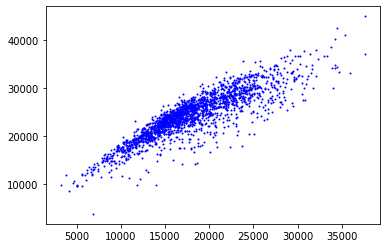

In [21]:
#There is not a clear visual division and clusters are assumed to be spherical and evenly sized, something which may reduce the accuracy of the K-means clustering Python results, let's see if yhe k-means algorithm can still classify with a good accuracy
plt.scatter(X_train[ : , 0], X_train[ : , 1], s =1, c='b')

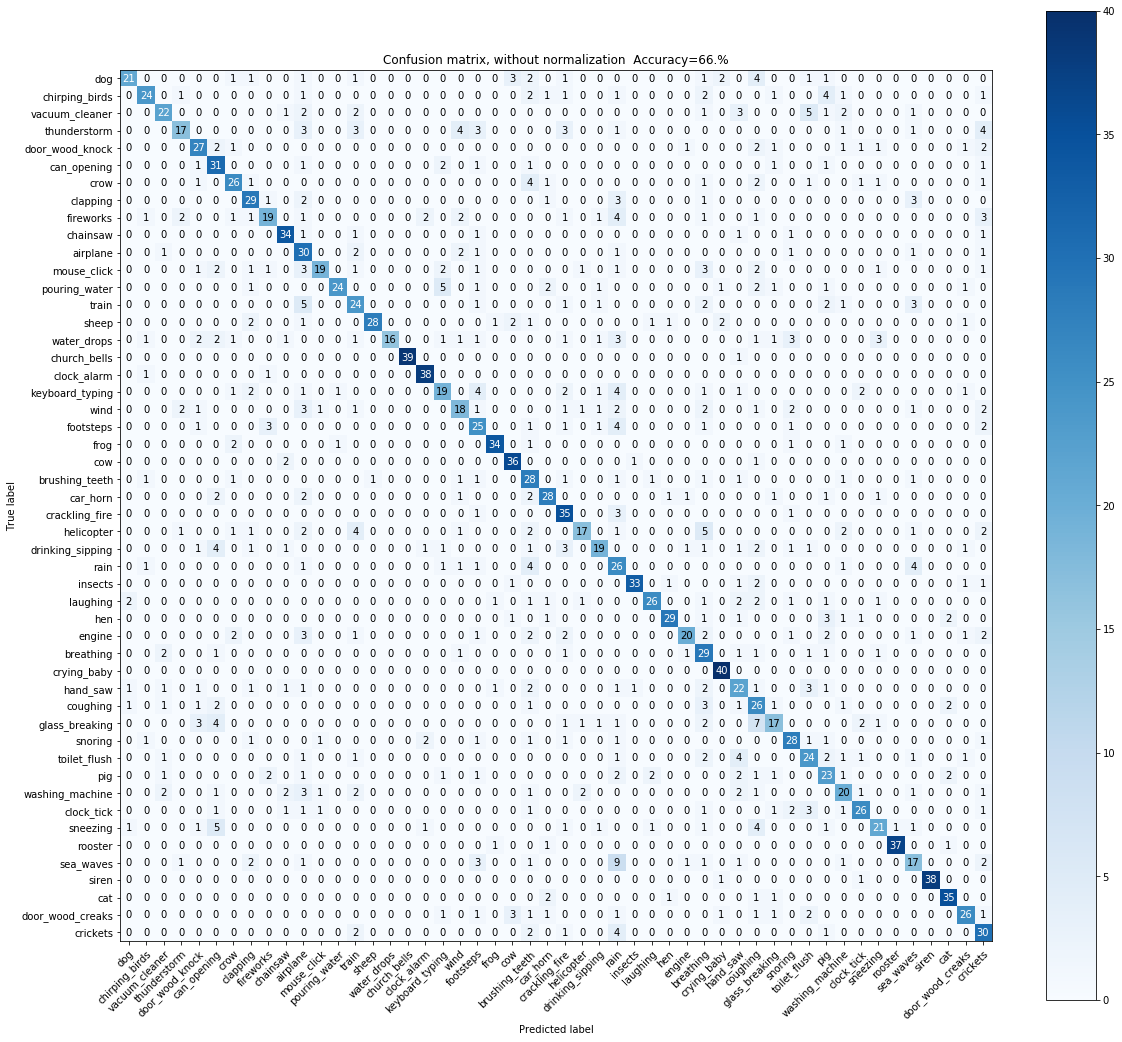

In [137]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#List with the 50 categories

cats=list()
cat_list=list()
for index, row in OriginalClass_klabel_pred.iterrows():
    Original_Class=row['Original_Class']
    cats.append(Original_Class)
    for i in cats:
          if (i not in cat_list):
            cat_list.append(i)
            
#list of predicted values that's going inside the confusion matrix
pred_list=list()
for index, row in OriginalClass_klabel_pred.iterrows():
    Predicted_Class=row['Predicted_class']
    for i in range(len(cat_list)):
        if(cat_list[i]==Predicted_Class):
            pred_list.append(i)
            
#list of true values that's going inside the confusion matrix
true_list=list() 
for index, row in OriginalClass_klabel_pred.iterrows():
    Original_Category=row['Original_Class']
    for i in range(len(cat_list)):
        if(cat_list[i]==Original_Category):
            true_list.append(i)
            
            
cat_names= np.array(cat_list)#array of categories



def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix  '
        else:
            title = 'Confusion matrix, without normalization  '

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
   
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(17,15))
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title+'Accuracy='+np.array2string(100*(np.trace(cm)/np.sum(cm)),precision=1)+'%',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
    


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(true_list, pred_list, classes=cat_names)
# Plot normalized confusion matrix
#plot_confusion_matrix(true_list, pred_list, classes=cat_names, normalize=True)

plt.show()

The accuracy using 1000 clusters is 66%

The following function gives just the accuracy result for a given number of clusters. Note: n_samples=2000 should be >= n_clusters

In [53]:
def just_accuracy(n_clusters):
    k_means = KMeans(n_clusters=n_clusters, n_init=10).fit(X_train)
    labels=k_means.labels_

    #I create a Data Frame with the original class and k label values

    OriginalClass=pd.DataFrame(y_train,columns=['Original_Class'])
    klabel=pd.DataFrame(labels,columns=['k_label'])
    OriginalClass_klabel=pd.concat((OriginalClass,klabel),axis=1)

    #I create a new column in the Data Frame with the predicted values. For this, I use the 'mayority vote', selecting, for each k_label value the most repeated Original_Class value throughout the data frame

    mode_k=list()
    for i in range(n_clusters):
        mode_k.append(OriginalClass_klabel[OriginalClass_klabel.k_label==i].Original_Class.mode()[0])
    predicted=list()
    for index,row in OriginalClass_klabel.iterrows():
        k_val=row['k_label']
        predicted.append(mode_k[k_val])
    predicted_df=pd.DataFrame(predicted, columns=['Predicted_class'])
    OriginalClass_klabel_pred=pd.concat((OriginalClass_klabel,predicted_df),axis=1)
    
    cats=list()
    cat_list=list()
    for index, row in OriginalClass_klabel_pred.iterrows():
        Original_Class=row['Original_Class']
        cats.append(Original_Class)
        for i in cats:
              if (i not in cat_list):
                cat_list.append(i)

    #list of predicted values that's going inside the confusion matrix
    pred_list=list()
    for index, row in OriginalClass_klabel_pred.iterrows():
        Predicted_Class=row['Predicted_class']
        for i in range(len(cat_list)):
            if(cat_list[i]==Predicted_Class):
                pred_list.append(i)

    #list of true values that's going inside the confusion matrix
    true_list=list() 
    for index, row in OriginalClass_klabel_pred.iterrows():
        Original_Category=row['Original_Class']
        for i in range(len(cat_list)):
            if(cat_list[i]==Original_Category):
                true_list.append(i)


    cat_names= np.array(cat_list)#array of categories
    
    cm = confusion_matrix(true_list, pred_list)
    print(n_clusters, 'clusters')
    print(np.array2string(100*(np.trace(cm)/np.sum(cm)),precision=1),'% accuracy')
           

Increasing k (n_clusters) without penalty will always reduce the amount of error in the resulting clustering, to the extreme case of zero error if each data point is considered its own cluster (i.e., when k equals the number of data points, n). In this case this can be easily seen in the accuracy result for 2000 clusters=number of data points, which accuracy is 100%

In [54]:
just_accuracy(100)

100 clusters
26.4 % accuracy


In [55]:
just_accuracy(200)

200 clusters
34.1 % accuracy


In [56]:
just_accuracy(300)

300 clusters
38. % accuracy


In [57]:
just_accuracy(500)

500 clusters
47.9 % accuracy


In [58]:
just_accuracy(1000)

1000 clusters
65.8 % accuracy


In [59]:
just_accuracy(1200)

1200 clusters
73.7 % accuracy


In [71]:
just_accuracy(2000)

2000 clusters
100. % accuracy


The accuracy increases proportionally with the number of clusters. The best result is for 2000 clusters, which is the maximum number of clusters I can use.The optimal choice of k will strike a balance between maximum compression of the data using a single cluster, and maximum accuracy by assigning each data point to its own cluster. If an appropriate value of k is not apparent from prior knowledge of the properties of the data set, it must be chosen somehow.There are several categories of methods for making this decision. 

**Feature variation**

In [89]:
#the following function gives the resulting accuracy for a certain feature set
def just_accuracy_feature_variation(X_train,Y_train,X_test,Y_test):
    X_train=np.concatenate((X_train,X_test),axis=0)
    y_train=np.append(Y_train,Y_test)
    k_means = KMeans(n_clusters=n_clusters, n_init=10).fit(X_train)
    labels=k_means.labels_

    #I create a Data Frame with the original class and k label values

    OriginalClass=pd.DataFrame(y_train,columns=['Original_Class'])
    klabel=pd.DataFrame(labels,columns=['k_label'])
    OriginalClass_klabel=pd.concat((OriginalClass,klabel),axis=1)

    #I create a new column in the Data Frame with the predicted values. For this, I use the 'mayority vote', selecting, for each k_label value the most repeated Original_Class value throughout the data frame

    mode_k=list()
    for i in range(n_clusters):
        mode_k.append(OriginalClass_klabel[OriginalClass_klabel.k_label==i].Original_Class.mode()[0])
    predicted=list()
    for index,row in OriginalClass_klabel.iterrows():
        k_val=row['k_label']
        predicted.append(mode_k[k_val])
    predicted_df=pd.DataFrame(predicted, columns=['Predicted_class'])
    OriginalClass_klabel_pred=pd.concat((OriginalClass_klabel,predicted_df),axis=1)
    
    cats=list()
    cat_list=list()
    for index, row in OriginalClass_klabel_pred.iterrows():
        Original_Class=row['Original_Class']
        cats.append(Original_Class)
        for i in cats:
              if (i not in cat_list):
                cat_list.append(i)

    #list of predicted values that's going inside the confusion matrix
    pred_list=list()
    for index, row in OriginalClass_klabel_pred.iterrows():
        Predicted_Class=row['Predicted_class']
        for i in range(len(cat_list)):
            if(cat_list[i]==Predicted_Class):
                pred_list.append(i)

    #list of true values that's going inside the confusion matrix
    true_list=list() 
    for index, row in OriginalClass_klabel_pred.iterrows():
        Original_Category=row['Original_Class']
        for i in range(len(cat_list)):
            if(cat_list[i]==Original_Category):
                true_list.append(i)


    cat_names= np.array(cat_list)#array of categories
    
    cm = confusion_matrix(true_list, pred_list)
    print(n_clusters, 'clusters')
    print(np.array2string(100*(np.trace(cm)/np.sum(cm)),precision=1),'% accuracy')
           

In [92]:
print('2 bins')
just_accuracy_feature_variation(X_train_2bins,Y_train_2bins_labels,X_test_2bins,Y_test_2bins_labels)
print('3 bins')
just_accuracy_feature_variation(X_train_3bins,Y_train_3bins_labels,X_test_3bins,Y_test_3bins_labels)
print('4 bins')
just_accuracy_feature_variation(X_train_4bins,Y_train_4bins_labels,X_test_4bins,Y_test_4bins_labels)
print('5 bins')
just_accuracy_feature_variation(X_train_5bins,Y_train_5bins_labels,X_test_5bins,Y_test_5bins_labels)
print('6 bins')
just_accuracy_feature_variation(X_train_6bins,Y_train_6bins_labels,X_test_6bins,Y_test_6bins_labels)
print('10 bins')
just_accuracy_feature_variation(X_train_10bins,Y_train_10bins_labels,X_test_10bins,Y_test_10bins_labels)

2 bins
300 clusters
38.1 % accuracy
3 bins
300 clusters
39.9 % accuracy
4 bins
300 clusters
39.5 % accuracy
5 bins
300 clusters
38.6 % accuracy
6 bins
300 clusters
37.5 % accuracy
10 bins
300 clusters
39. % accuracy


The algorithm doesn't seem to have a big improvement changing the features.

# Hierarchical Agglomerative Clustering

HAC has a "bottom-up" approach: each observation starts in its own cluster, and pairs of clusters are merged as one moves up the hierarchy.

In order to decide which clusters should be combined (for agglomerative), or where a cluster should be split (for divisive), a measure of dissimilarity between sets of observations is required. This is achieved by use of the Kolmogorov distance metric (a measure of distance between pairs of observations), and a linkage criterion which specifies the dissimilarity of sets as a function of the pairwise distances of observations in the sets. 

Steps:

-Take featureset of 6bins -Obtain Kolmogorov distances -Build distance matrix -Use clustering algorithm with distance matrix -Plot confusion matrix and accuracy for different numbers of clusters -Plot dendrogram

In [64]:
bins=6#I keep using the feature set of 6 bins
print(X_train.shape)#2000x54 matrix of features
print(y_train.shape)#2000x1 matrix of labels (the classes) for each file

(2000, 54)
(2000,)


In [65]:
#in this cell I calculate the KV distance matrix using the feature set of 6bins
distance_matrix=np.zeros([2000,2000])
for i in range(2000):
    for j in range(2000):
        if(j==i):
            continue
        if(j<i):
            continue
        else:
            fi=X_train[i:(i+1),0:(3*bins)].flatten()
            fj=X_train[j:(j+1),0:(3*bins)].flatten()
            si=X_train[i:(i+1),(3*bins):(6*bins)].flatten()
            sj=X_train[j:(j+1),(3*bins):(6*bins)].flatten()
            Ei=X_train[i:(i+1),(6*bins):(9*bins)].flatten()
            Ej=X_train[j:(j+1),(6*bins):(9*bins)].flatten()
            D_f_tract,p= stats.ks_2samp(fi, fj)
            D_s_tract,p= stats.ks_2samp(si, sj)
            D_E,p=stats.ks_2samp(Ei, Ej)
            E_distance=(D_f_tract*D_f_tract)+(D_s_tract*D_s_tract)+(D_E*D_E)
            E_distance=math.sqrt(E_distance)
            distance_matrix[i][j]=E_distance
            distance_matrix[j][i]=distance_matrix[i][j]#simetric

In [66]:
#Save the 'distance_matrix' in an h5py file
distance_matrix_h = h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/' + 'distance_matrix.hdf5', mode = 'w')
distance_matrix_h.create_dataset('distance_matrix', data=distance_matrix)
distance_matrix_h.close()

In [24]:
#Read the 'distance_matrix' file
distance_matrix_h=h5py.File('/home/mitsy/mysandbox/aml-aed-challenge-mitsyprada/' + 'distance_matrix.hdf5', mode = 'r+')
distance_matrix_h.keys()

<KeysViewHDF5 ['distance_matrix']>

In [37]:
distance_matrix=distance_matrix_h['distance_matrix']

In [25]:
#Data frame with indexes and category of each file corresponding to that index
csv = pd.read_csv (r'/home/mitsy/mysandbox/data/ESC-50-master/meta/esc50.csv')
cat_column = pd.DataFrame(csv, columns= ['category'])
index_cat=list()   
for index, row in cat_column.iterrows():
        categories = row['category']
        one_index_one_cat=[index,categories]
        index_cat.append(one_index_one_cat)
index_cat_df=pd.DataFrame(index_cat, columns= ['index','category'])
index_cat_df

index        category
0         0             dog
1         1  chirping_birds
2         2  vacuum_cleaner
3         3  vacuum_cleaner
4         4    thunderstorm
...     ...             ...
1995   1995             hen
1996   1996  vacuum_cleaner
1997   1997       footsteps
1998   1998           sheep
1999   1999             dog

[2000 rows x 2 columns]

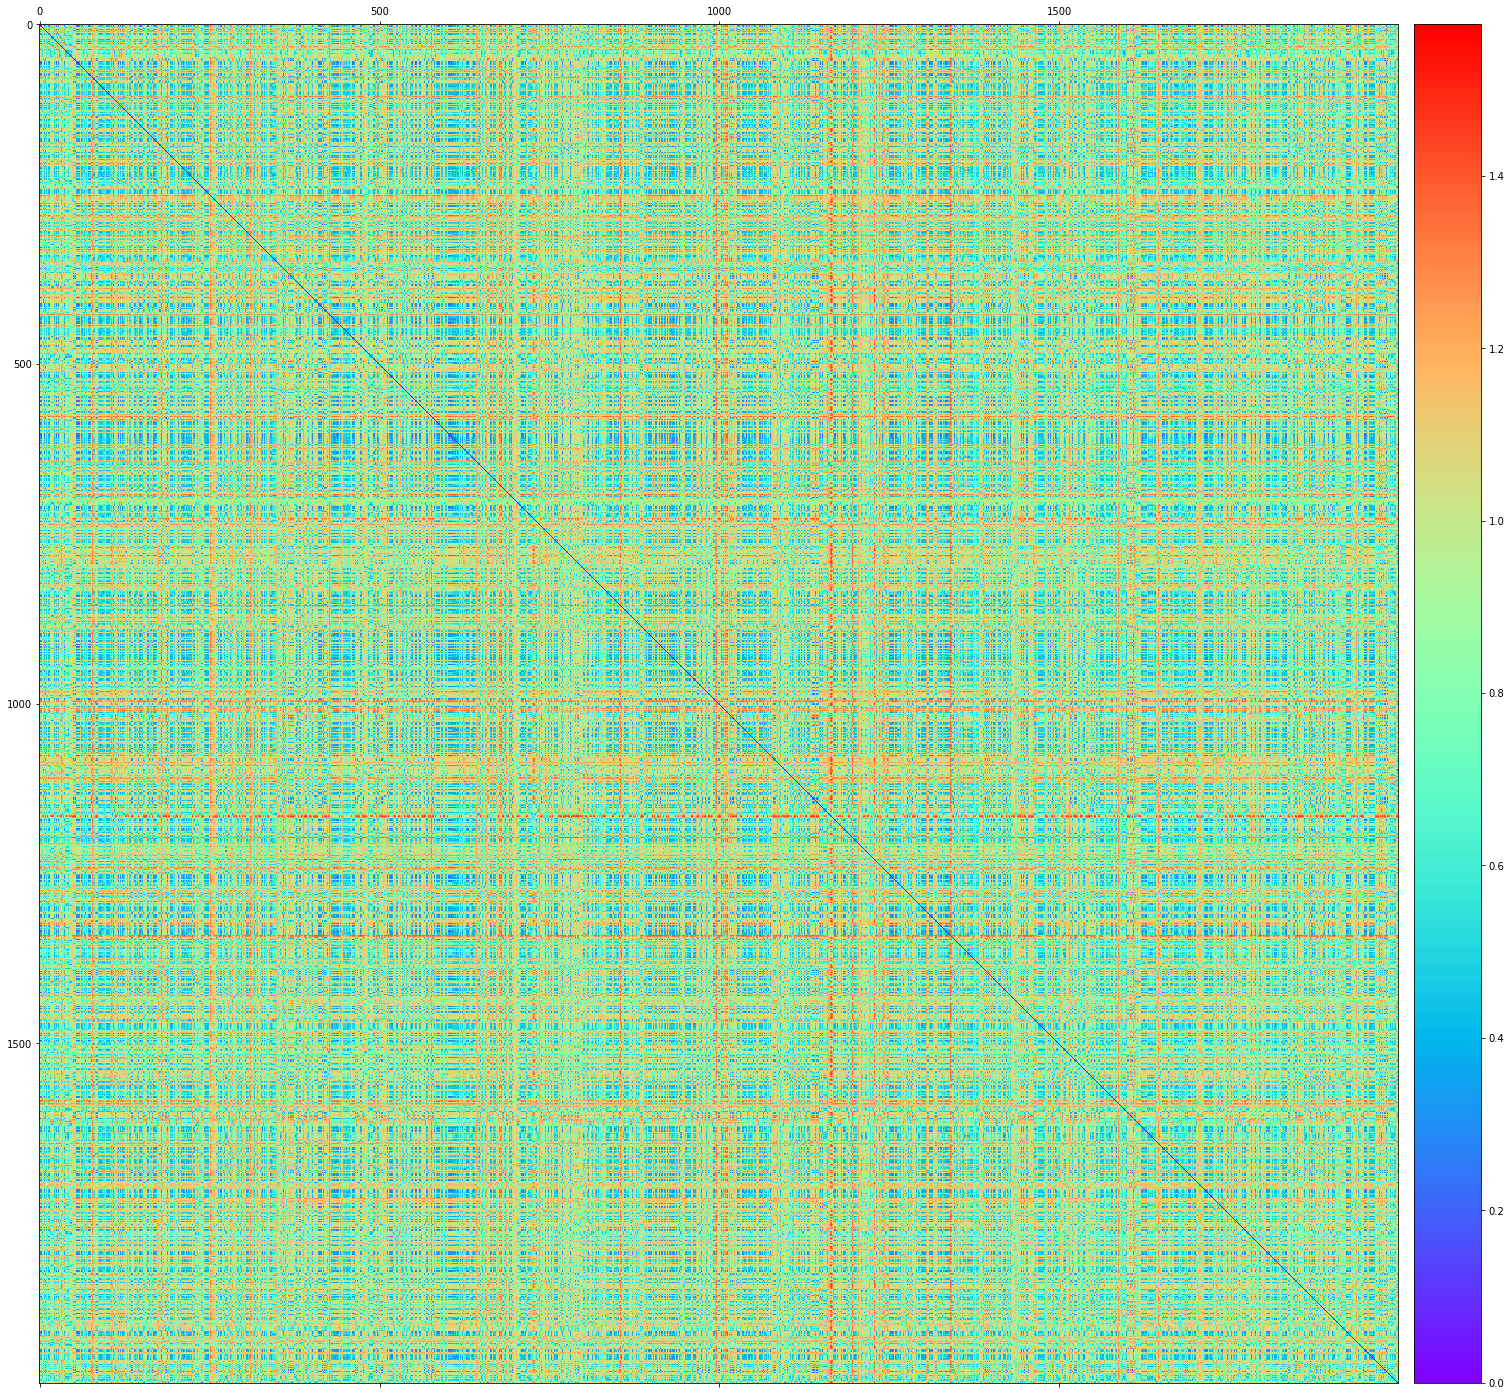

In [75]:
#Representation of distance matrix. 
#Note: I have commented out the axis ticks because this is a distance matrix of 2000 files and the category of each file would be written one on top of eachother, making it an unreadable mess

indexes=list()
for index, row in index_cat_df.iterrows():
       indexes.append(index)
#v=list(csv.iloc[indexes]['category'])
fig, ax = plt.subplots(figsize=(27,25))
im=ax.matshow(distance_matrix[:,:], interpolation='nearest', cmap=cm.rainbow)
ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.01)
# ax.set_ylim(bottom=len(v)-5,top=0.5)
#ax.set_xticks(range(len(v)))
#ax.set_yticks(range(len(v)))
#ax.set(xticklabels=v,yticklabels=v)
#plt.setp(ax.get_xticklabels(), rotation=45, rotation_mode="anchor", ha="left")
plt.show()

                                                                                    Kolmogorov distance matrix. 

In [146]:
#aglomerative clustering algorithm
n_clusters=1000
AgglomerativeClustering=AgglomerativeClustering(n_clusters=n_clusters,affinity='precomputed',linkage='average').fit(distance_matrix)
AC_labels=AgglomerativeClustering.labels_

#data frame with index, original category, AC labels and predicted category
AC_labels_df=pd.DataFrame(AC_labels, columns=['AC_label'])
#dataframe with three first columns: index, category and aglomerative clustering labels
Idx_OCat_AClabel=pd.concat((index_cat_df,AC_labels_df),axis=1)
#list of predicted categories
Idx_OCat_AClabel
mode_AC=list()
for i in range(n_clusters):
    mode_AC.append(Idx_OCat_AClabel[Idx_OCat_AClabel.AC_label==i].category.mode()[0])
    
list1=list()
for index, row in Idx_OCat_AClabel.iterrows():
    AC_values=row['AC_label']
    list1.append(mode_AC[AC_values])

list1_df=pd.DataFrame(list1, columns=['Predicted_category'])
index_originalCat_AC_predictedCat=pd.concat((Idx_OCat_AClabel,list1_df),axis=1)
index_originalCat_AC_predictedCat

index        category  AC_label Predicted_category
0         0             dog       233     glass_breaking
1         1  chirping_birds       210     chirping_birds
2         2  vacuum_cleaner       116               rain
3         3  vacuum_cleaner       116               rain
4         4    thunderstorm       841       thunderstorm
...     ...             ...       ...                ...
1995   1995             hen       357                cat
1996   1996  vacuum_cleaner       324     vacuum_cleaner
1997   1997       footsteps        30        can_opening
1998   1998           sheep        57           car_horn
1999   1999             dog       248                dog

[2000 rows x 4 columns]

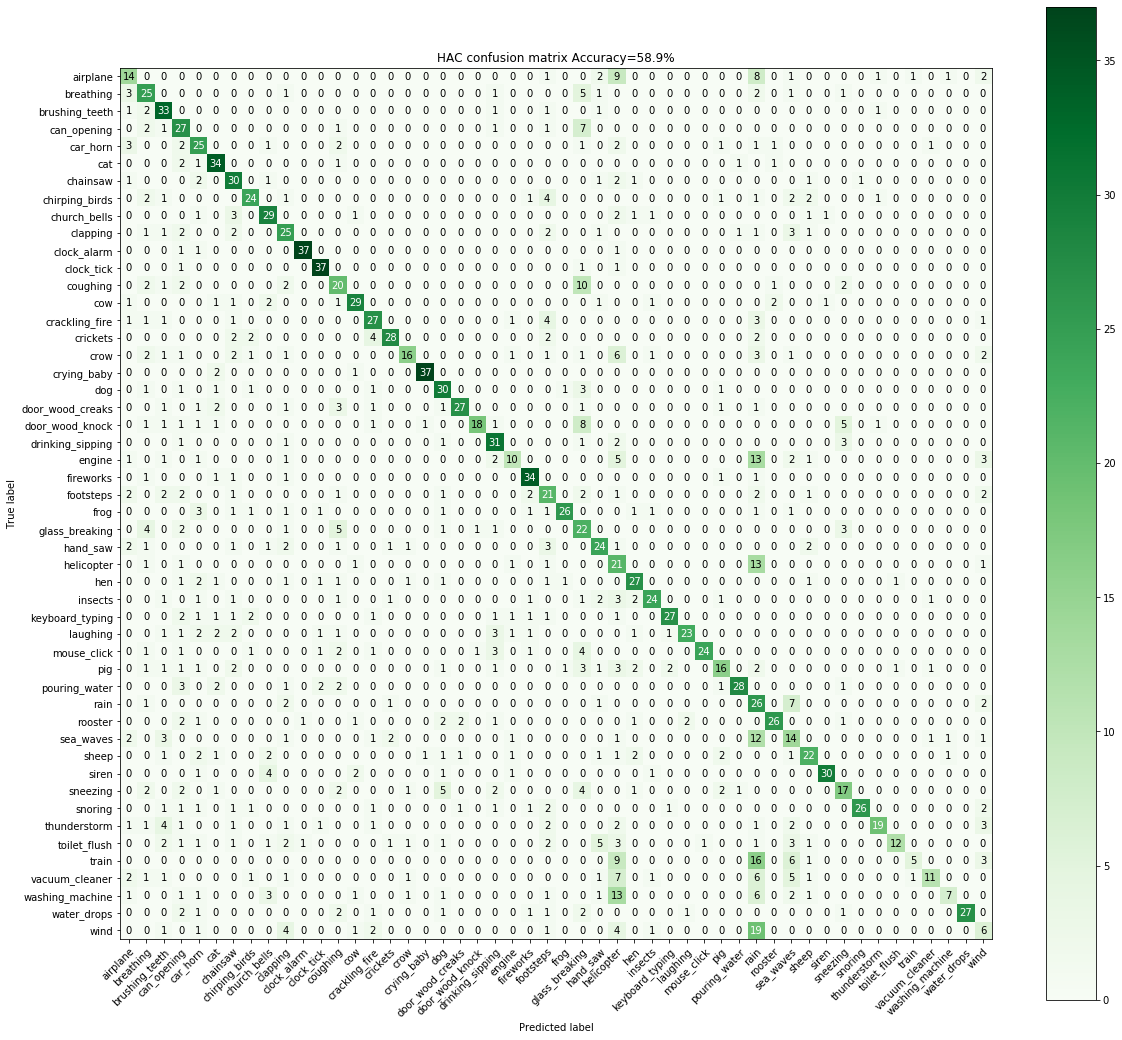

In [138]:
#list of true values that's going inside the confusion matrix
cat_names=np.unique(y_train)
true_list=list() 
for index, row in index_originalCat_AC_predictedCat.iterrows():
    Original_Category=row['category']
    for i in range(len(cat_names)):
        if(cat_names[i]==Original_Category):
            true_list.append(i)
            
#list of predicted values that's going inside the confusion matrix            
pred_list=list()
for index, row in index_originalCat_AC_predictedCat.iterrows():
    Predicted_Category=row['Predicted_category']
    for i in range(len(cat_names)):
        if(cat_names[i]==Predicted_Category):
            pred_list.append(i)

#calls a function previously created in the k-means section
plot_confusion_matrix(true_list, pred_list, classes=cat_names, normalize=False,title='HAC confusion matrix ',cmap=plt.cm.Greens)
plt.show()

In [152]:
indexes=list()
for index, row in index_originalCat_AC_predictedCat.iterrows():
       indexes.append(index)


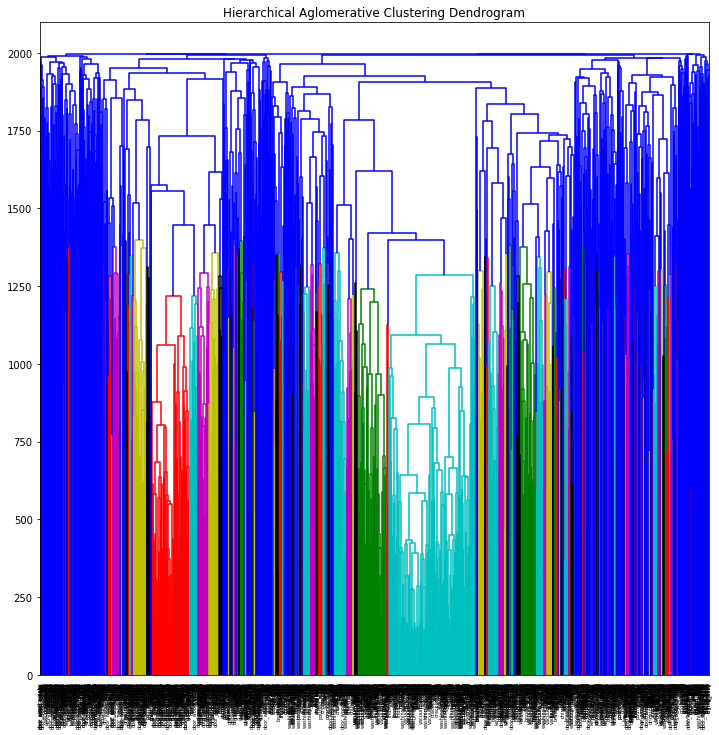

In [153]:
#HAC Dendrogram
from scipy.cluster.hierarchy import dendrogram

indexes=list()
for index, row in index_originalCat_AC_predictedCat.iterrows():
       indexes.append(index)
v=list(csv.iloc[indexes]['category'])
plt.figure(figsize=(17, 15))
plt.title('Hierarchical Aglomerative Clustering Dendrogram')
linkage_matrix = np.column_stack([AgglomerativeClustering.children_,np.arange(AgglomerativeClustering.children_.shape[0]),np.arange(2, AgglomerativeClustering.children_.shape[0]+2)]).astype(float)
dendrogram(linkage_matrix, labels=v)
plt.show()

The HAC dendrogram includes 2000 files, therefore is the lines cannot be very separated and it is not very visually informative of the algorithm.

In [54]:
#Here I made a function that calculated the accuracy for a given number of clusters
def just_accuracy(n_clusters):
    from sklearn.cluster import AgglomerativeClustering
    #aglomerative clustering algorithm
    AgglomerativeClustering=AgglomerativeClustering(n_clusters=n_clusters,affinity='precomputed',linkage='average').fit(distance_matrix)
    AC_labels=AgglomerativeClustering.labels_

    #data frame with index, original category, AC labels and predicted category
    AC_labels_df=pd.DataFrame(AC_labels, columns=['AC_label'])
    #dataframe with three first columns: index, category and aglomerative clustering labels
    Idx_OCat_AClabel=pd.concat((index_cat_df,AC_labels_df),axis=1)
    #list of predicted categories
    Idx_OCat_AClabel
    mode_AC=list()
    for i in range(n_clusters):
        mode_AC.append(Idx_OCat_AClabel[Idx_OCat_AClabel.AC_label==i].category.mode()[0])

    list1=list()
    for index, row in Idx_OCat_AClabel.iterrows():
        AC_values=row['AC_label']
        list1.append(mode_AC[AC_values])

    list1_df=pd.DataFrame(list1, columns=['Predicted_category'])
    index_originalCat_AC_predictedCat=pd.concat((Idx_OCat_AClabel,list1_df),axis=1)
    #list of true values that's going inside the confusion matrix
    cat_names=np.unique(y_train)
    true_list=list() 
    for index, row in index_originalCat_AC_predictedCat.iterrows():
        Original_Category=row['category']
        for i in range(len(cat_names)):
            if(cat_names[i]==Original_Category):
                true_list.append(i)

    #list of predicted values that's going inside the confusion matrix            
    pred_list=list()
    for index, row in index_originalCat_AC_predictedCat.iterrows():
        Predicted_Category=row['Predicted_category']
        for i in range(len(cat_names)):
            if(cat_names[i]==Predicted_Category):
                pred_list.append(i)
    
    cm = confusion_matrix(true_list, pred_list)
    print(n_clusters, 'clusters')
    print(np.array2string(100*(np.trace(cm)/np.sum(cm)),precision=1),'% accuracy')
           

In [55]:
just_accuracy(1000)

1000 clusters
58.9 % accuracy


In [56]:
just_accuracy(100)

100 clusters
16.9 % accuracy


In [57]:
just_accuracy(200)

200 clusters
22.7 % accuracy


In [58]:
just_accuracy(300)

300 clusters
28.2 % accuracy


In [59]:
just_accuracy(400)

400 clusters
32.8 % accuracy


In [60]:
just_accuracy(500)

500 clusters
37.4 % accuracy


In [61]:
just_accuracy(600)

600 clusters
41.6 % accuracy


In [62]:
just_accuracy(700)

700 clusters
46.3 % accuracy


In [63]:
just_accuracy(800)

800 clusters
50.4 % accuracy


In [64]:
just_accuracy(1000)

1000 clusters
58.9 % accuracy


In [65]:
just_accuracy(1500)

1500 clusters
80. % accuracy


In [66]:
just_accuracy(1800)

1800 clusters
92. % accuracy


In [67]:
just_accuracy(2000)

2000 clusters
100. % accuracy


# Conclusions

**SVM feature variation**

2 bins
| C: 1| Gamma: auto
accuracy score = 28.375%
________________________________________________________________
3 bins
| C: 1| Gamma: auto
accuracy score = 28.125%
________________________________________________________________
4 bins
| C: 1| Gamma: auto
accuracy score = 28.875%
________________________________________________________________
5 bins
| C: 1| Gamma: auto
accuracy score = 29.5%
________________________________________________________________
6 bins
| C: 1| Gamma: auto
accuracy score = 30.0%
________________________________________________________________
10 bins
| C: 1| Gamma: auto
accuracy score = 30.125%
________________________________________________________________


**SVM gamma variation**

6 bins
| C: 1| Gamma: 0.0033333333333333335
accuracy score = 30.0%
________________________________________________________________
| C: 1| Gamma: 0.009259259259259259
accuracy score = 30.0%
________________________________________________________________
| C: 1| Gamma: 0.018518518518518517
accuracy score = 30.0%
________________________________________________________________
| C: 1| Gamma: 1
accuracy score = 30.0%
________________________________________________________________
| C: 1| Gamma: 10
accuracy score = 30.0%


**SVM c variation**

6 bins
| C: 0.01| Gamma: auto
accuracy score = 30.0%
________________________________________________________________
| C: 0.2| Gamma: auto
accuracy score = 30.0%
________________________________________________________________
| C: 0.5| Gamma: auto
accuracy score = 30.0%
________________________________________________________________
| C: 1| Gamma: auto
accuracy score = 30.0%
________________________________________________________________
| C: 300| Gamma: auto
accuracy score = 30.0%
________________________________________________________________


**K-means based on mayority vote, n_clusters variation**


100 clusters
26.4 % accuracy


200 clusters
34.1 % accuracy


300 clusters 38. % accuracy


500 clusters
47.9 % accuracy


1000 clusters
65.8 % accuracy


1200 clusters
73.7 % accuracy


2000 clusters 100. % accuracy


**K-means based on mayority vote, feature variation**

n_clusters=300


2 bins
38.1 % accuracy

3 bins
39.9 % accuracy

4 bins
39.5 % accuracy

5 bins
38.6 % accuracy

6 bins
37.5 % accuracy

10 bins 39. % accuracy


**HAC, n_clusters variation**



100 clusters
16.9 % accuracy


200 clusters
22.7 % accuracy


300 clusters
28.2 % accuracy


400 clusters
32.8 % accuracy


500 clusters
37.4 % accuracy


600 clusters
41.6 % accuracy


700 clusters
46.3 % accuracy


800 clusters
50.4 % accuracy


1000 clusters
58.9 % accuracy


1500 clusters 80. % accuracy


1800 clusters 92. % accuracy


2000 clusters 100. % accuracy


SVM is fundamentaly a binary classifier. If we have multiple classes, we end up doing one versus rest, and the classes overlap. This is why the accuracy is poor. The k-means and HAC have simmilar accuracies for the same features set, but K-means is slightly better. SVM is not adecuate for classifying sounds into 50 classes, but it would be if there were a much smaller ammount of classes. K-means is the best option but it requires further study about the optimum number of clusters to choose (more clusters>>more expensive, less clusters>>less accuracy). The features set could be significantly improved if the characteristic frecuencies of each class were studied further (plotting and analyzing more histrograms, for each slice that the f_tract, s_tract and E features are divided, dividing them into more than 3 slices), obtaining more characteristic frecuency patterns for each class.